# Initial Setup

In [629]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics
import requests
import csv
import time
import datetime
import itertools
from dateutil.relativedelta import relativedelta

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal

import pmdarima as pm
import prophet
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model
from Gridsearch_Calc_Profit import Gridsearch_Calc_Profit
from Model_Historical_Simuluation import Model_Historical_Simuluation
# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get NYSE calendar

In [3]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [4]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [5]:
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# EOD Historical API

In [321]:
url = 'https://eodhistoricaldata.com/api/options/SPY.US?api_token\
=60611d449c48f9.42617904&from=2021-03-31&to=2021-04-05'
response = requests.get(url)
data = response.json()

In [6]:
data.keys()

dict_keys(['code', 'exchange', 'lastTradeDate', 'lastTradePrice', 'data'])

In [7]:
data['data'][0].keys()

dict_keys(['expirationDate', 'impliedVolatility', 'optionsCount', 'options'])

In [8]:
data['data'][0]['expirationDate'], data['data'][1]['expirationDate'], data['data'][2]['expirationDate'], 

('2021-03-31', '2021-04-01', '2021-04-05')

In [9]:
april_1_opt = data['data'][1]['options']
april_1_opt

{'CALL': [{'contractName': 'SPY210401C00190000',
   'contractSize': 'REGULAR',
   'currency': 'USD',
   'type': 'CALL',
   'inTheMoney': 'TRUE',
   'lastTradeDateTime': '2021-03-23 10:09:46',
   'expirationDate': '2021-04-01',
   'strike': 190,
   'lastPrice': 202.65,
   'bid': 210.62,
   'ask': 211.38,
   'change': 202.65,
   'changePercent': None,
   'volume': 10,
   'openInterest': 10,
   'impliedVolatility': 641.4923,
   'delta': 0.9919,
   'gamma': 0.0002,
   'theta': -1.4897,
   'vega': 0.0046,
   'rho': 0.0033,
   'theoretical': 211,
   'intrinsicValue': 0,
   'timeValue': 0,
   'updatedAt': '2021-04-01 18:54:19',
   'daysBeforeExpiration': 0},
  {'contractName': 'SPY210401C00195000',
   'contractSize': 'REGULAR',
   'currency': 'USD',
   'type': 'CALL',
   'inTheMoney': 'TRUE',
   'lastTradeDateTime': '2021-04-01 09:32:23',
   'expirationDate': '2021-04-01',
   'strike': 195,
   'lastPrice': 203.44,
   'bid': 205.62,
   'ask': 206.38,
   'change': 5.83,
   'changePercent': 0.02

In [322]:
april_1_opt = data['data'][1]['options']
spy_call_df = pd.DataFrame.from_records(april_1_opt['CALL'])
spy_call_df

,contractName,contractSize,contractPeriod,currency,type,inTheMoney,lastTradeDateTime,expirationDate,strike,lastPrice,bid,ask,change,changePercent,volume,openInterest,impliedVolatility,delta,gamma,theta,vega,rho,theoretical,intrinsicValue,timeValue,updatedAt,daysBeforeExpiration
0,SPY210401C00190000,REGULAR,,USD,CALL,TRUE,2021-03-23 10:09:46,2021-04-01,190.0,202.65,210.62,211.38,202.65,NaN,10.0,10.0,641.4923,0.9919,0.0002,-1.4897,0.0046,0.0033,211.00,0,0,2021-04-01 18:54:19,0
1,SPY210401C00195000,REGULAR,,USD,CALL,TRUE,2021-04-01 09:32:23,2021-04-01,195.0,203.44,205.62,206.38,5.83,0.0295,20.0,20.0,620.9751,0.9916,0.0002,-1.4837,0.0047,0.0034,206.00,0,0,2021-04-01 18:54:19,0
2,SPY210401C00200000,REGULAR,,USD,CALL,TRUE,2021-03-11 10:32:56,2021-04-01,200.0,192.80,200.62,201.38,2.30,0.0121,2.0,1.0,600.9673,0.9914,0.0002,-1.4775,0.0049,0.0035,201.00,0,0,2021-04-01 18:54:19,0
3,SPY210401C00205000,REGULAR,,USD,CALL,TRUE,0000-00-00 00:00:00,2021-04-01,205.0,191.30,195.62,196.38,191.30,NaN,20.0,10.0,581.4410,0.9911,0.0002,-1.4711,0.0050,0.0036,196.00,0,0,2021-04-01 18:48:19,0
4,SPY210401C00210000,REGULAR,,USD,CALL,TRUE,0000-00-00 00:00:00,2021-04-01,210.0,0.00,190.62,191.38,0.00,NaN,NaN,NaN,562.3703,0.9908,0.0002,-1.4645,0.0052,0.0037,191.00,0,0,2021-04-01 18:48:19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,SPY210401C00465000,REGULAR,,USD,CALL,FALSE,2021-03-12 14:13:54,2021-04-01,465.0,0.01,0.01,0.01,0.00,0.0000,29.0,223.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
130,SPY210401C00470000,REGULAR,,USD,CALL,FALSE,2021-03-09 15:07:03,2021-04-01,470.0,0.01,0.01,0.01,0.00,0.0000,1.0,59.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
131,SPY210401C00480000,REGULAR,,USD,CALL,FALSE,2021-03-02 14:35:39,2021-04-01,480.0,0.02,0.01,0.01,0.02,NaN,24.0,35.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
132,SPY210401C00490000,REGULAR,,USD,CALL,FALSE,2021-03-02 12:33:44,2021-04-01,490.0,0.01,0.00,0.01,0.00,0.0000,4.0,1.0,127.7593,0.0013,0.0002,-0.0598,0.0009,0.0000,0.01,0,0,2021-04-01 18:54:19,0


In [10]:
april_1_opt = data['data'][1]['options']
spy_call_df = pd.DataFrame.from_records([i 
                                         for i in april_1_opt['CALL']])
spy_call_df

,contractName,contractSize,currency,type,inTheMoney,lastTradeDateTime,expirationDate,strike,lastPrice,bid,ask,change,changePercent,volume,openInterest,impliedVolatility,delta,gamma,theta,vega,rho,theoretical,intrinsicValue,timeValue,updatedAt,daysBeforeExpiration
0,SPY210401C00190000,REGULAR,USD,CALL,TRUE,2021-03-23 10:09:46,2021-04-01,190.0,202.65,210.62,211.38,202.65,NaN,10.0,10.0,641.4923,0.9919,0.0002,-1.4897,0.0046,0.0033,211.00,0,0,2021-04-01 18:54:19,0
1,SPY210401C00195000,REGULAR,USD,CALL,TRUE,2021-04-01 09:32:23,2021-04-01,195.0,203.44,205.62,206.38,5.83,0.0295,20.0,20.0,620.9751,0.9916,0.0002,-1.4837,0.0047,0.0034,206.00,0,0,2021-04-01 18:54:19,0
2,SPY210401C00200000,REGULAR,USD,CALL,TRUE,2021-03-11 10:32:56,2021-04-01,200.0,192.80,200.62,201.38,2.30,0.0121,2.0,1.0,600.9673,0.9914,0.0002,-1.4775,0.0049,0.0035,201.00,0,0,2021-04-01 18:54:19,0
3,SPY210401C00205000,REGULAR,USD,CALL,TRUE,0000-00-00 00:00:00,2021-04-01,205.0,191.30,195.62,196.38,191.30,NaN,20.0,10.0,581.4410,0.9911,0.0002,-1.4711,0.0050,0.0036,196.00,0,0,2021-04-01 18:48:19,0
4,SPY210401C00210000,REGULAR,USD,CALL,TRUE,0000-00-00 00:00:00,2021-04-01,210.0,0.00,190.62,191.38,0.00,NaN,NaN,NaN,562.3703,0.9908,0.0002,-1.4645,0.0052,0.0037,191.00,0,0,2021-04-01 18:48:19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,SPY210401C00465000,REGULAR,USD,CALL,FALSE,2021-03-12 14:13:54,2021-04-01,465.0,0.01,0.01,0.01,0.00,0.0000,29.0,223.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
130,SPY210401C00470000,REGULAR,USD,CALL,FALSE,2021-03-09 15:07:03,2021-04-01,470.0,0.01,0.01,0.01,0.00,0.0000,1.0,59.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
131,SPY210401C00480000,REGULAR,USD,CALL,FALSE,2021-03-02 14:35:39,2021-04-01,480.0,0.02,0.01,0.01,0.02,NaN,24.0,35.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0,0,2021-04-01 18:54:19,0
132,SPY210401C00490000,REGULAR,USD,CALL,FALSE,2021-03-02 12:33:44,2021-04-01,490.0,0.01,0.00,0.01,0.00,0.0000,4.0,1.0,127.7593,0.0013,0.0002,-0.0598,0.0009,0.0000,0.01,0,0,2021-04-01 18:54:19,0


In [11]:
april_1_opt = data['data'][1]['options']
spy_put_df = pd.DataFrame.from_records([i for i in april_1_opt['PUT']])
spy_put_df

,contractName,contractSize,currency,type,inTheMoney,lastTradeDateTime,expirationDate,strike,lastPrice,bid,ask,change,changePercent,volume,openInterest,impliedVolatility,delta,gamma,theta,vega,rho,theoretical,intrinsicValue,timeValue,updatedAt,daysBeforeExpiration
0,SPY210401P00190000,REGULAR,USD,PUT,FALSE,2021-03-17 13:58:45,2021-04-01,190.0,0.01,0.01,0.01,0.00,0.0000,102.0,389.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
1,SPY210401P00195000,REGULAR,USD,PUT,FALSE,2021-03-10 14:42:05,2021-04-01,195.0,0.01,0.01,0.01,0.00,0.0000,80.0,437.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
2,SPY210401P00200000,REGULAR,USD,PUT,FALSE,2021-03-19 13:00:19,2021-04-01,200.0,0.01,0.01,0.01,0.00,0.0000,5834.0,6723.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
3,SPY210401P00205000,REGULAR,USD,PUT,FALSE,2021-04-01 16:04:21,2021-04-01,205.0,0.01,0.01,0.01,0.00,0.0000,1.0,1009.0,399.5424,-0.0004,0.0,-0.066,0.0003,0.0,0.01,0,0,2021-04-01 18:54:19,0
4,SPY210401P00210000,REGULAR,USD,PUT,FALSE,2021-03-12 11:37:36,2021-04-01,210.0,0.01,0.01,0.01,-0.01,-0.5000,1.0,85.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,SPY210401P00465000,REGULAR,USD,PUT,TRUE,2021-03-29 11:22:55,2021-04-01,465.0,70.28,63.63,64.36,-5.31,-0.0702,10.0,18.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
130,SPY210401P00470000,REGULAR,USD,PUT,TRUE,2021-03-26 15:54:53,2021-04-01,470.0,75.76,68.63,69.36,-4.16,-0.0521,6.0,1.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0
131,SPY210401P00480000,REGULAR,USD,PUT,TRUE,0000-00-00 00:00:00,2021-04-01,480.0,0.00,78.63,79.36,0.00,NaN,NaN,NaN,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:48:20,0
132,SPY210401P00490000,REGULAR,USD,PUT,TRUE,2021-03-31 10:42:07,2021-04-01,490.0,93.08,88.63,89.36,-2.20,-0.0231,14.0,5.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.00,0,0,2021-04-01 18:54:19,0


In [15]:
# spy_opt_df = pd.DataFrame.from_dict({i: april_1_opt_dict[i][0]
#                         for i in april_1_opt_dict},
#                        orient='index')
# spy_opt_df

In [16]:
url = 'https://eodhistoricaldata.com/api/options/SPY.US?api_token\
=60611d449c48f9.42617904&from=2018-07-02&to=2018-07-06'
response = requests.get(url)
data = response.json()

In [17]:
[date['expirationDate'] for date in data['data']]

['2018-07-02', '2018-07-03', '2018-07-06']

# Alpha Vantage

## Setup

### Initialize Alpha Vantage parameters

In [18]:
ts = TimeSeries(key=av_key, output_format='csv')
AV_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume']

## Gather Data

### Last Two Years, 60min

In [19]:
# df_full = get_av_all_data_slices('SPY', ts, interval='60min', verbose=0)
# df_full.to_csv('../data/SPY_2019_2021.csv')

### Last Month, 60min

In [20]:
# df_last_month = get_av_all_data_slices('SPY', ts, y=1, m=1, interval='60min', verbose=0)
# df_last_month.index = pd.to_datetime(df_last_month.index)
# df_last_month.to_csv('../data/SPY_Last_Month_CBH.csv')

### Last 5 days, 1min

In [21]:
# df_last_month_1min = get_av_all_data_slices('SPY', ts, y=1, m=1, interval='1min', verbose=1)
# df_last_month_1min.index = pd.to_datetime(df_last_month_1min.index)
# df_last_month_1min.to_csv('../data/SPY_Last_Month_1min.csv')

In [22]:
# df_last_5d_1min = df_last_month_1min[df_last_month_1min.index.date > (df_last_month_1min[:1].index.date - 5*cbd)]
# df_last_5d_1min.to_csv('../data/SPY_Last_5d_1min.csv')

In [23]:
# df_last_1min[:1].index.date - 5*cbd

In [24]:
# (pd.date_range(df_last_month_1min[:1].index[0], periods = 5, freq=-cbd)).date

In [25]:
# ticker = 'SPY'
# date= 'year1month10'
# apiKey = av_key

# df_new = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+ticker+'&interval=60min&slice='+date+'&apikey='+apiKey+'&datatype=csv&outputsize=full') 

## Load Data from File

In [26]:
# df_full = pd.read_csv('../data/SPY_2019_2021_CBH.csv', index_col='time')
df_full = pd.read_csv('../data/SPY_2019_2021_CBD.csv', index_col='time')
df_full.index = pd.to_datetime(df_full.index)

In [27]:
df_last_month = pd.read_csv('../data/SPY_Last_Month_CBH.csv', index_col='time')
df_last_month.index = pd.to_datetime(df_last_month.index)

In [28]:
df_last_5d_1min = pd.read_csv('../data/SPY_Last_5d_1min.csv', index_col='time')
df_last_5d_1min.index = pd.to_datetime(df_last_5d_1min.index)

## Append Latest Data

## Data Preparation

### Set Frequencies

In [33]:
df_full = df_full.sort_index()
df_full = df_full.asfreq(CBD)

In [30]:
df_last_month = df_last_month.sort_index()
df_last_month = df_last_month.asfreq(cbh)

In [34]:
df_last_5d_1min = df_last_5d_1min.sort_index()
df_last_5d_1min = df_last_5d_1min.asfreq('T')

In [35]:
df_last_5d_1min

,open,high,low,close,volume
time,,,,,
2021-04-22 04:01:00,415.61,415.61,415.52,415.60,9244.0
2021-04-22 04:02:00,415.63,415.63,415.60,415.61,2860.0
2021-04-22 04:03:00,415.60,415.64,415.60,415.61,2990.0
2021-04-22 04:04:00,415.63,415.63,415.63,415.63,510.0
2021-04-22 04:05:00,415.63,415.66,415.61,415.65,1011.0
...,...,...,...,...,...
2021-04-28 19:56:00,418.40,418.44,418.40,418.44,6269.0
2021-04-28 19:57:00,418.44,418.48,418.44,418.48,1574.0
2021-04-28 19:58:00,418.46,418.50,418.46,418.50,2127.0


### EDA

In [36]:
df_full.isna().sum(), df_last_month.isna().sum(), df_last_5d_1min.isna().sum()

(open      0
 high      0
 low       0
 close     0
 volume    0
 dtype: int64,
 open      16
 high      16
 low       16
 close     16
 volume    16
 dtype: int64,
 open      5673
 high      5673
 low       5673
 close     5673
 volume    5673
 dtype: int64)

In [37]:
pd.DataFrame(df_full.index.date).value_counts(), pd.DataFrame(df_last_month.index.date).value_counts(), pd.DataFrame(df_last_5d_1min.index.date).value_counts()

(2019-05-07    1
 2020-08-20    1
 2020-09-09    1
 2020-09-08    1
 2020-09-04    1
              ..
 2019-12-23    1
 2019-12-20    1
 2019-12-19    1
 2019-12-18    1
 2021-04-23    1
 Length: 496, dtype: int64,
 2021-03-30    16
 2021-03-31    16
 2021-04-27    16
 2021-04-26    16
 2021-04-23    16
 2021-04-22    16
 2021-04-21    16
 2021-04-20    16
 2021-04-19    16
 2021-04-16    16
 2021-04-15    16
 2021-04-14    16
 2021-04-13    16
 2021-04-12    16
 2021-04-09    16
 2021-04-08    16
 2021-04-07    16
 2021-04-06    16
 2021-04-05    16
 2021-04-02    16
 2021-04-01    16
 2021-04-28    16
 dtype: int64,
 2021-04-23    1440
 2021-04-24    1440
 2021-04-25    1440
 2021-04-26    1440
 2021-04-27    1440
 2021-04-28    1201
 2021-04-22    1199
 dtype: int64)

In [38]:
# try:
#     assert(type(df_new)=='pandas.core.frame.DataFrame')
# except AssertionError:
#     print('Nothing to append.')
# else:
#     df_full = df_full.append(df_new)
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
# finally:
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
#     df_full

### Create Time Series for `Close`, `Volume`

In [39]:
df_full_close = df_full.close
df_last_month_close = df_last_month.close
df_last_5d_1min_close = df_last_5d_1min.close
print(df_last_month_close[-16:])
print()
print(df_last_5d_1min_close[-60:])

time
2021-04-28 05:00:00    417.8700
2021-04-28 06:00:00    417.7900
2021-04-28 07:00:00    417.9000
2021-04-28 08:00:00    417.4600
2021-04-28 09:00:00    417.6800
2021-04-28 10:00:00    418.3800
2021-04-28 11:00:00    418.0319
2021-04-28 12:00:00    417.2919
2021-04-28 13:00:00    417.8090
2021-04-28 14:00:00    417.3100
2021-04-28 15:00:00    418.3300
2021-04-28 16:00:00    417.3500
2021-04-28 17:00:00    418.0800
2021-04-28 18:00:00    418.0000
2021-04-28 19:00:00    418.2200
2021-04-28 20:00:00    418.4700
Freq: CBH, Name: close, dtype: float64

time
2021-04-28 19:01:00    418.30
2021-04-28 19:02:00    418.27
2021-04-28 19:03:00    418.29
2021-04-28 19:04:00    418.30
2021-04-28 19:05:00       NaN
                        ...  
2021-04-28 19:56:00    418.44
2021-04-28 19:57:00    418.48
2021-04-28 19:58:00    418.50
2021-04-28 19:59:00    418.49
2021-04-28 20:00:00    418.47
Freq: T, Name: close, Length: 60, dtype: float64


In [40]:
vol_full = df_full.volume
vol_last_month = df_last_month.volume
vol_last_5d_1min = df_last_5d_1min.volume
print(vol_last_month[-16:])
print()
print(vol_last_5d_1min[-60:])

time
2021-04-28 05:00:00       19891.0
2021-04-28 06:00:00        9111.0
2021-04-28 07:00:00       27097.0
2021-04-28 08:00:00      156203.0
2021-04-28 09:00:00       80054.0
2021-04-28 10:00:00     5654960.0
2021-04-28 11:00:00     4954183.0
2021-04-28 12:00:00     4875257.0
2021-04-28 13:00:00     2933922.0
2021-04-28 14:00:00     2843849.0
2021-04-28 15:00:00     9781781.0
2021-04-28 16:00:00    15078124.0
2021-04-28 17:00:00     3608693.0
2021-04-28 18:00:00      186049.0
2021-04-28 19:00:00      128157.0
2021-04-28 20:00:00       42013.0
Freq: CBH, Name: volume, dtype: float64

time
2021-04-28 19:01:00    6142.0
2021-04-28 19:02:00     605.0
2021-04-28 19:03:00     605.0
2021-04-28 19:04:00     100.0
2021-04-28 19:05:00       NaN
                        ...  
2021-04-28 19:56:00    6269.0
2021-04-28 19:57:00    1574.0
2021-04-28 19:58:00    2127.0
2021-04-28 19:59:00    4522.0
2021-04-28 20:00:00    2319.0
Freq: T, Name: volume, Length: 60, dtype: float64


In [41]:
df_full.index, df_last_month.index, df_last_5d_1min.index

(DatetimeIndex(['2019-05-07 05:00:00', '2019-05-08 05:00:00',
                '2019-05-09 05:00:00', '2019-05-10 05:00:00',
                '2019-05-13 05:00:00', '2019-05-14 05:00:00',
                '2019-05-15 05:00:00', '2019-05-16 05:00:00',
                '2019-05-17 05:00:00', '2019-05-20 05:00:00',
                ...
                '2021-04-12 05:00:00', '2021-04-13 05:00:00',
                '2021-04-14 05:00:00', '2021-04-15 05:00:00',
                '2021-04-16 05:00:00', '2021-04-19 05:00:00',
                '2021-04-20 05:00:00', '2021-04-21 05:00:00',
                '2021-04-22 05:00:00', '2021-04-23 05:00:00'],
               dtype='datetime64[ns]', name='time', length=496, freq='C'),
 DatetimeIndex(['2021-03-30 05:00:00', '2021-03-30 06:00:00',
                '2021-03-30 07:00:00', '2021-03-30 08:00:00',
                '2021-03-30 09:00:00', '2021-03-30 10:00:00',
                '2021-03-30 11:00:00', '2021-03-30 12:00:00',
                '2021-03-30 13:00:00

In [ ]:
vol_full, vol_last_month, vol_last_5d_1min

## Plot PACF

In [ ]:
plot_pacf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

In [ ]:
plot_pacf_with_diff(df_last_5d_1min_close, 'SPY \'Close\'', '5 Days', '1 Min')

## Plot ACF

In [ ]:
plot_acf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

## Plot Seasonal Decomposition

### 2019-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY', round(365/4), 'days')

### Last Month, Freq = Custom Business Hour, 5 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY', 16*5, 'hours')

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

### Test out read and write CSV at same time

In [ ]:
# with open('../data/GME_intra_Mar_29_Apr_12.csv', newline='') as csvfile:
# #     fieldnames = ['first_name', 'last_name']
#     reader = csv.reader(csvfile)
#     fieldnames = next(reader)
#     print(fieldnames)
    
#     with open('../data/output.csv', mode='w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(fieldnames)
#         for row in reader:
#             writer.writerow(row)
            

### Scratch

In [ ]:
# df_full[df_full.index>'2020-07-03']

In [ ]:
# df_full[(df_full.index>'2020-07-03') & (df_full.index<'2020-07-04')]

In [ ]:
# start = pd.to_datetime('2019-06-07')

In [ ]:
# cbh.next_bday(pd.to_datetime(start))

In [ ]:
# start + pd.DateOffset(days = 2)

In [ ]:
# start + pd.offsets.BDay()

In [ ]:
# df_copy = df_full.copy()
# df_copy.index = df_copy.index.date
# df_copy.index.value_counts()

In [ ]:
# df_copy_2 = df_full2.copy()
# df_copy_2.index = df_copy_2.index.date
# df_copy_2.index.value_counts()

In [ ]:
# df_full2[df_full2.index.date == pd.to_datetime('2020-07-06')]

In [ ]:
# df_full[df_full.index.date == pd.to_datetime('2021-03-01')]

In [ ]:
# null_data = df_full[df_full.isnull().any(axis=1)]
# null_data

In [ ]:
# null_data2 = df_full2[df_full2.isnull().any(axis=1)]
# null_data2

In [ ]:
# y=1
# m=11
# data_slice = f'year{y+1}month{m+1}'
# print(data_slice)
# total_data_reader, total_meta_data = ts.get_intraday_extended(symbol='SPY', interval='60min', slice=data_slice)
# fieldnames = next(total_data_reader)
# print(fieldnames)
# df_test = pd.DataFrame(total_data_reader, columns=fieldnames)
# df_test.set_index('time', inplace=True)
# df_test

In [ ]:
# with open('../data/output.csv', mode='w', newline='') as csvfile:
# #     writer = csv.DictWriter(csvfile, fieldnames=df_test_dict.keys())
# #     writer = csv.DictWriter(sys.stderr, fieldnames=df_test_dict.keys())
# #     writer = csv.writer(sys.stderr)
#     writer = csv.writer(csvfile)
#     writer.writerow(df_test.reset_index().columns)
# #     writer.writeheader()
#     writer.writerows(df_test.reset_index().values)

In [ ]:
# df_test_close = df_test.close

## Check Stationarity

In [ ]:
test_stationarity(df_full_close.dropna())
print()
test_stationarity(df_last_month_close.dropna())
print()
test_stationarity(df_last_5d_1min_close.dropna())

In [ ]:
test_stationarity(df_full_close.dropna(), 1)
print()
test_stationarity(df_last_month_close.dropna(), 1)
print()
test_stationarity(df_last_5d_1min_close.dropna(), 1)

## Plot PACF

In [ ]:
plot_pacf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

In [ ]:
plot_pacf_with_diff(df_last_5d_1min_close, 'SPY \'Close\'', '5 Days', '1 Min')

## Plot ACF

In [ ]:
plot_acf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

## Plot Seasonal Decomposition

### 2019-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY', round(365/4), 'days')

### Last Month, Freq = Custom Business Hour, 5 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY', 16*5, 'hours')

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

In [ ]:
decomp = seasonal_decompose(df_last_5d_1min_close.dropna(), period=int(6.5*60))
dc_obs = decomp.observed
dc_trend = decomp.trend
dc_seas = decomp.seasonal
dc_resid = decomp.resid
dc_df = pd.DataFrame({"observed": dc_obs, "trend": dc_trend,
                            "seasonal": dc_seas, "residual": dc_resid})

In [ ]:
dc_df.iloc[:,0].index[0]

In [ ]:
dc_df.iloc[:,0].dropna()

In [ ]:
pd.date_range(dc_df.iloc[:,0][.size)

In [ ]:
range(dc_df.iloc[:,0].size)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(dc_df.iloc[:,0].dropna().size), dc_df.iloc[:,0].dropna())
# ax.set_xticklabels(dc_df.dropna().index.date.tolist());
ax.set_xticklabels(dc_df.iloc[:,0].dropna().index.date.tolist());
fig.autofmt_xdate()

In [ ]:
fig, ax = plt.subplots()
ax.plot(dc_df.iloc[:,0].dropna().index, dc_df.iloc[:,0].dropna())
# ax.set_xticklabels(dc_df.dropna().index.date.tolist());
# fig.autofmt_xdate()

In [ ]:
dc_df.dropna().index.date.tolist()

In [ ]:
dc_df.iloc[:,0].dropna().index.date.tolist()

In [ ]:
delta={}
delta['minutes'] = 15

In [ ]:
end = dc_df.iloc[:, 0].index[-1] + relativedelta(**delta)
end

In [ ]:
new = dc_df.iloc[:,0].resample('T').mean()

In [ ]:
new.dropna().plot()

# YFinance

## Setup / Gather Data

In [6]:
symbol = 'SPY'
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

## Load Data from File

In [7]:
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)

## Data Preparation

### EDA

In [76]:
spy_df_3Y

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900
...,...,...,...,...,...,...
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700
2021-05-06,415.829987,419.209991,413.679993,419.070007,419.070007,74321400
2021-05-07,419.890015,422.820007,419.160004,422.119995,422.119995,67680100


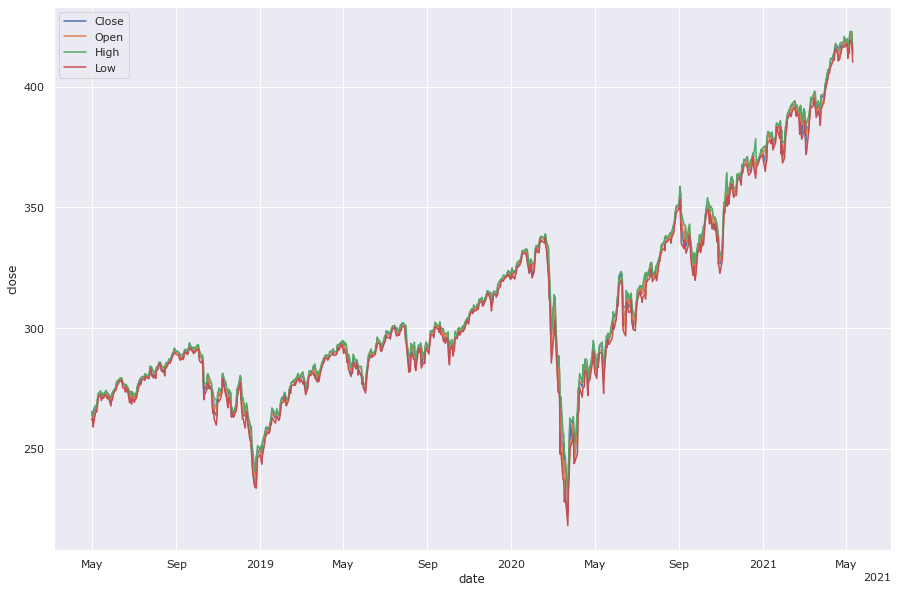

In [105]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x="date", y='close', data=spy_df_3Y, ax=ax, label='Close')
sns.lineplot(x="date", y='open', data=spy_df_3Y, ax=ax, label='Open')
sns.lineplot(x="date", y='high', data=spy_df_3Y, ax=ax, label='High')
sns.lineplot(x="date", y='low', data=spy_df_3Y, ax=ax, label='Low')
ax.legend()

In [115]:
new_spy = spy_df_3Y.reset_index()
new_spy['test'] = np.arange(0,new_spy.shape[0])

No handles with labels found to put in legend.


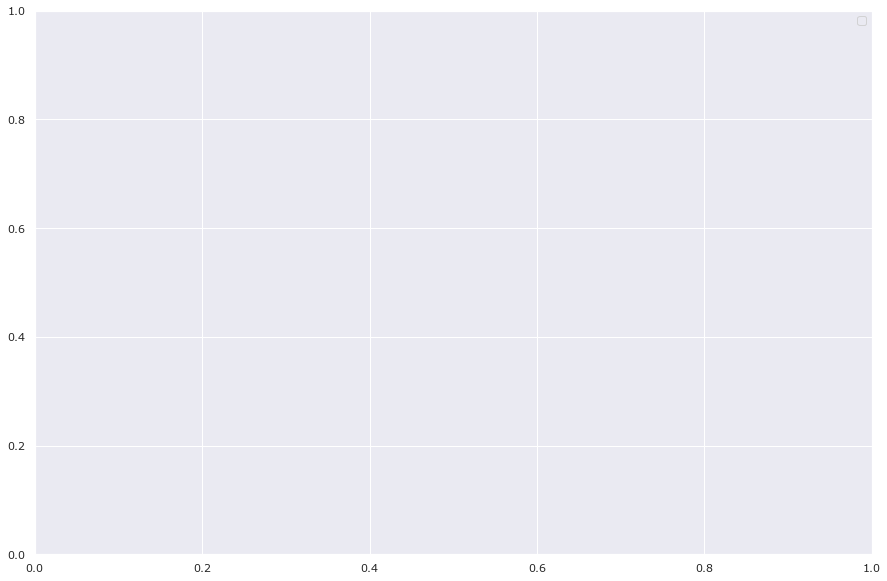

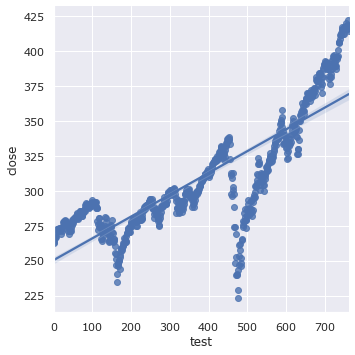

In [116]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lmplot(x="test", y='close', data=new_spy)
# sns.lineplot(x="date", y='open', data=spy_df_3Y, ax=ax, label='Open')
# sns.lineplot(x="date", y='high', data=spy_df_3Y, ax=ax, label='High')
# sns.lineplot(x="date", y='low', data=spy_df_3Y, ax=ax, label='Low')
ax.legend()

In [ ]:
sns.relplot(data=spy_df_3Y.reset_index(), x='date')

In [8]:
spy_df_3Y.index

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10',
               '2018-05-11', '2018-05-14',
               ...
               '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-03',
               '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
               '2021-05-10', '2021-05-11'],
              dtype='datetime64[ns]', name='date', length=763, freq=None)

### Set up Frequency

In [9]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [10]:
spy_df_all.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Create Time Series for `Close`, `Volume`

In [11]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.volume
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.volume
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.volume
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.volume
df_all_open = spy_df_all.open

In [12]:
df_all_close

date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
2021-05-10    417.940002
2021-05-11    414.209991
Freq: C, Name: close, Length: 7122, dtype: float64

## Plot PACF

In [13]:
plot_pacf_with_diff(df_full_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_vol' is not defined

In [14]:
plot_pacf_with_diff(df_full_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_close' is not defined

## Plot ACF

In [15]:
plot_acf_with_diff(df_full_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_vol' is not defined

In [16]:
plot_acf_with_diff(df_full_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_close' is not defined

## Plot Seasonal Decomposition

In [ ]:
start = pd.to_datetime('2020-07-01')

In [ ]:
freq =  '1 Day'
freq.split()[1].lower() + 's'

### 2018-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 365)

### 5 Years, Freq = Custom Business Hour, 1 Year Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 252)

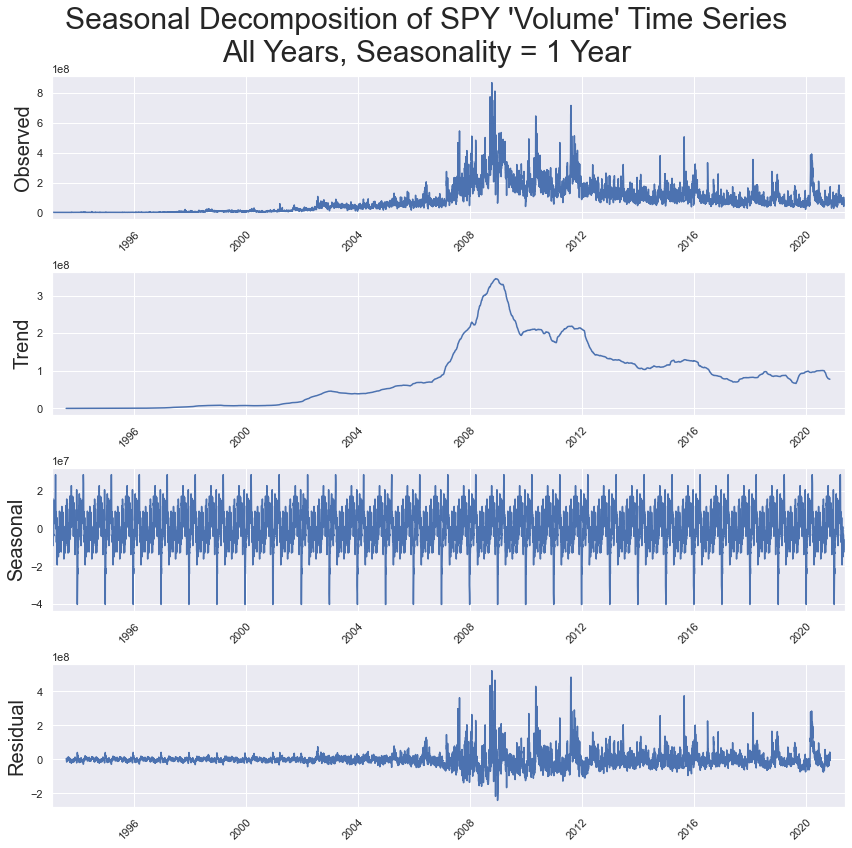

In [630]:
plot_seasonal_decomposition(df_all_vol, 'SPY \'Volume\'', 'All', 'years', '1 Day', 252)

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

# Quandl

# Engineering

## `is_option_expiry` Binary Variable

In [409]:
# end = pd.Timestamp.today() + 2*252*CBD
# end

Timestamp('2023-05-09 21:52:22.455978')

In [398]:
# date = pd.date_range(start=spy_df_all.index[0], end=end, freq=MWF)
# N = date.size
# date

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-03', '1993-02-05',
               '1993-02-08', '1993-02-10', '1993-02-12', '1993-02-15',
               '1993-02-17', '1993-02-19',
               ...
               '2023-04-17', '2023-04-19', '2023-04-21', '2023-04-24',
               '2023-04-26', '2023-04-28', '2023-05-01', '2023-05-03',
               '2023-05-05', '2023-05-08'],
              dtype='datetime64[ns]', length=4739, freq='C')

In [388]:
# MWF = pd.offsets.CustomBusinessDay(weekmask = 'Mon Wed Fri')
# opt_exp_df = pd.DataFrame(zip(date, np.zeros(N), np.zeros(N), np.ones(N)), columns=['date', 'on_offset', 'to_offset', 'is_expiry_date'])
# opt_exp_df['on_offset'] = opt_exp_df.apply(__is_on_offset, args=([CBD]), axis=1)
# # opt_exp_df['to_offset'] = np.select(conditions, choices, default = 0)
# opt_exp_df['to_offset'] = __option_expiry_offset(opt_exp_df)
# opt_exp_df['date'] = opt_exp_df['date'] + CBD*opt_exp_df['to_offset']
# opt_exp_df.drop(['on_offset', 'to_offset'], axis=1, inplace=True)
# opt_exp_df.drop_duplicates('date', ignore_index=True, inplace=True)
# opt_exp_df.set_index('date', inplace=True)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1108: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized



In [684]:
# opt_exp_all_df = opt_exp_df.truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
# opt_exp_10Y_df = opt_exp_all_df.truncate(before=spy_df_10Y.index[0])
# opt_exp_5Y_df = opt_exp_10Y_df.truncate(before=spy_df_5Y.index[0])
# opt_exp_3Y_df = opt_exp_5Y_df.truncate(before=spy_df_3Y.index[0])

In [20]:
opt_exp_3Y_df = create_option_expiry_df(date_index=spy_df_3Y.index, func='historical', freq=CBD)
opt_exp_5Y_df = create_option_expiry_df(date_index=spy_df_5Y.index, func='historical', freq=CBD)
opt_exp_10Y_df = create_option_expiry_df(date_index=spy_df_10Y.index, func='historical', freq=CBD)
opt_exp_all_df = create_option_expiry_df(date_index=spy_df_all.index, func='historical', freq=CBD)

### Build next x days

In [21]:
opt_exp_fc_df = create_option_expiry_df(N=52, func='forecast', freq=CBD)

In [779]:
opt_exp_all_df

,is_option_expiry
date,
1993-01-29,1
1993-02-01,1
1993-02-02,0
1993-02-03,1
1993-02-04,0
...,...
2021-05-04,0
2021-05-05,1
2021-05-06,0


In [665]:
opt_exp_all_df 

,is_option_expiry
date,
1993-01-29,1
1993-02-01,1
1993-02-02,0
1993-02-03,1
1993-02-04,0
...,...
2021-05-04,0
2021-05-05,1
2021-05-06,0


In [459]:
# Pickle
option_expiry_dfs = (opt_exp_3Y_df, opt_exp_5Y_df, opt_exp_10Y_df, opt_exp_all_df, opt_exp_fc_df)
pickle_data(option_expiry_dfs, f'{TOP}/data/prepared_data/option_expiry_dfs.pkl')

File exists, overwriting.
Saved to /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data/prepared_data/option_expiry_dfs.pkl.


# Modeling

In [ ]:
opt_exp_3Y_df

## Last 3 Years, 1 Day

### Using only is_option_expiry as exogenous variable

In [469]:
verbose=1
debug=True

In [757]:
all_exog_df

,date,is_option_expiry,volume
7121,2021-05-11,0,7.167447e+07
7122,2021-05-12,1,7.161890e+07
7123,2021-05-13,0,7.158267e+07
7124,2021-05-14,1,7.087480e+07
7125,2021-05-17,1,6.080668e+07
...,...,...,...
7168,2021-07-15,0,6.843055e+07
7169,2021-07-16,1,6.822505e+07
7170,2021-07-19,1,5.886877e+07
7171,2021-07-20,0,6.531081e+07


In [772]:
hist_df.isna().sum()

date                  0
is_option_expiry      0
volume              256
dtype: int64

In [829]:
max_mod = 1
mod_count = 0
for i in range(10):
    for j in range(10):
        mod_count += 1
        if max_mod and mod_count>=max_mod:
            break
        print(mod_count)
    print(i*2)
print()
print(mod_count)

0
2
4
6
8
10
12
14
16
18

10


Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
min_p 5
Building list of models to test.
ARIMA Order(5, 1, 5)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(6, 1, 4)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already presen

________________________________________________________________________

Running step-wise cross-validation on model 1 of 4... 
ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(5, 1, 6), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4223.757 | RMSE: 3.501 | RMSE%=1.196% | SMAPE 0.736%
Successfully completed step-wise CV on model.
Model[ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4223.757 | RMSE=3.501 | RMSE_pc=1.196% | SMAPE=0.736%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=3.501
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_3Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_3Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 942.
Adding scores to model, updating line 942.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 4... 
ARIMA Order(5, 1, 7)['t

> 

Done.
AIC: 4221.788 | RMSE: 3.646 | RMSE%=1.246% | SMAPE 0.780%
Successfully completed step-wise CV on model.
Model[ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer]: AIC=4221.788 | RMSE=3.646 | RMSE_pc=1.246% | SMAPE=0.780%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 943.
Adding scores to model, updating line 943.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 4... 
ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(6, 1, 5), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4223.280 | RMSE: 3.519 | RMSE%=1.202% | SMAPE 0.739%
Successfully completed step-wise CV on model.
Model[ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4223.280 | RMSE=3.519 | RMSE_pc=1.202% | SMAPE=0.739%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 944.
Adding scores to model, updating line 944.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 4... 
ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(6, 1, 6), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4222.863 | RMSE: 3.505 | RMSE%=1.198% | SMAPE 0.742%
Successfully completed step-wise CV on model.
Model[ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4222.863 | RMSE=3.505 | RMSE_pc=1.198% | SMAPE=0.742%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 945.
Adding scores to model, updating line 945.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4223.757 | RMSE=3.501 | RMSE%=1.196% | SMAPE=0.736%
Model[ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4222.863 | RMSE=3.505 | RMSE%=1.198% | SMAPE=0.742%
Model[ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4223.280 | RMSE=3.519 | RMSE%=1.202% | SMAPE=0.739%
Model[ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer]: AIC=4221.788 | RMSE=3.646 | RMSE%=1.246% | SMAPE=0.780%


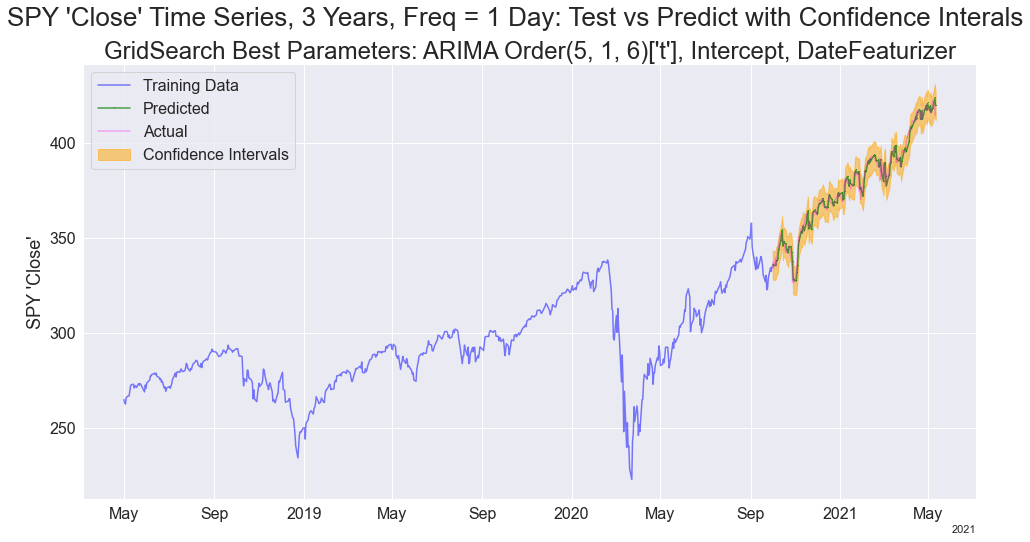

In [55]:
pam_3Y_close = Pmdarima_Model(df_3Y_close, 'SPY \'Close\'', n=3, periods='years', freq='1 Day', train_size=80,
                        order=(0,1,0), f_seas=252, fit_seas=False, #with_intercept=False, trend='t',
                        estimate_diffs=True, impute=False, verbose=1, k=4,
                        date=True, fourier=False, box=False, log=False)
pam_3Y_best, scores = pam_3Y_close.run_gridsearch_CV(min_order=10, max_order=12, min_d=1, max_d=1, min_p=5, max_p=6, min_q=4, max_q=10,
                                    with_intercept=True, f_m=252, k=2, t_list=['t'],
                                    fourier=False, box=False, log=False, max_models=0, debug=True, verbose=1, parallel=False)

In [758]:
pam_all_model.predict(n_periods=1, X=all_exog_df)

array([418.8308205 , 418.74824802, 418.6711355 , 418.66232616,
       418.57768906, 418.93163898, 418.91614048, 419.10816405,
       419.01602361, 419.03635296, 419.18785824, 419.24313888,
       419.36354925, 419.30172703, 419.46439002, 419.70543544,
       419.93702144, 419.98302039, 419.97819953, 419.99254548,
       420.11753392, 420.24425234, 420.27164923, 420.29658964,
       420.27432283, 420.43172888, 420.53372404, 420.57532868,
       420.59570247, 420.56603992, 420.73614073, 420.82232545,
       420.87945998, 420.88564239, 420.86362031, 421.02960716,
       421.11505699, 421.51284517, 421.51179587, 421.60854483,
       421.54894265, 421.74597036, 421.8028085 , 421.80206363,
       421.7915211 , 421.94409912, 422.0366026 , 422.08932433,
       422.09112619, 422.0780204 , 422.23108588, 422.32321235])

Successfully created instance of Class Pmdarima_Model.
Using class variable 'df' - original DataFrame.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


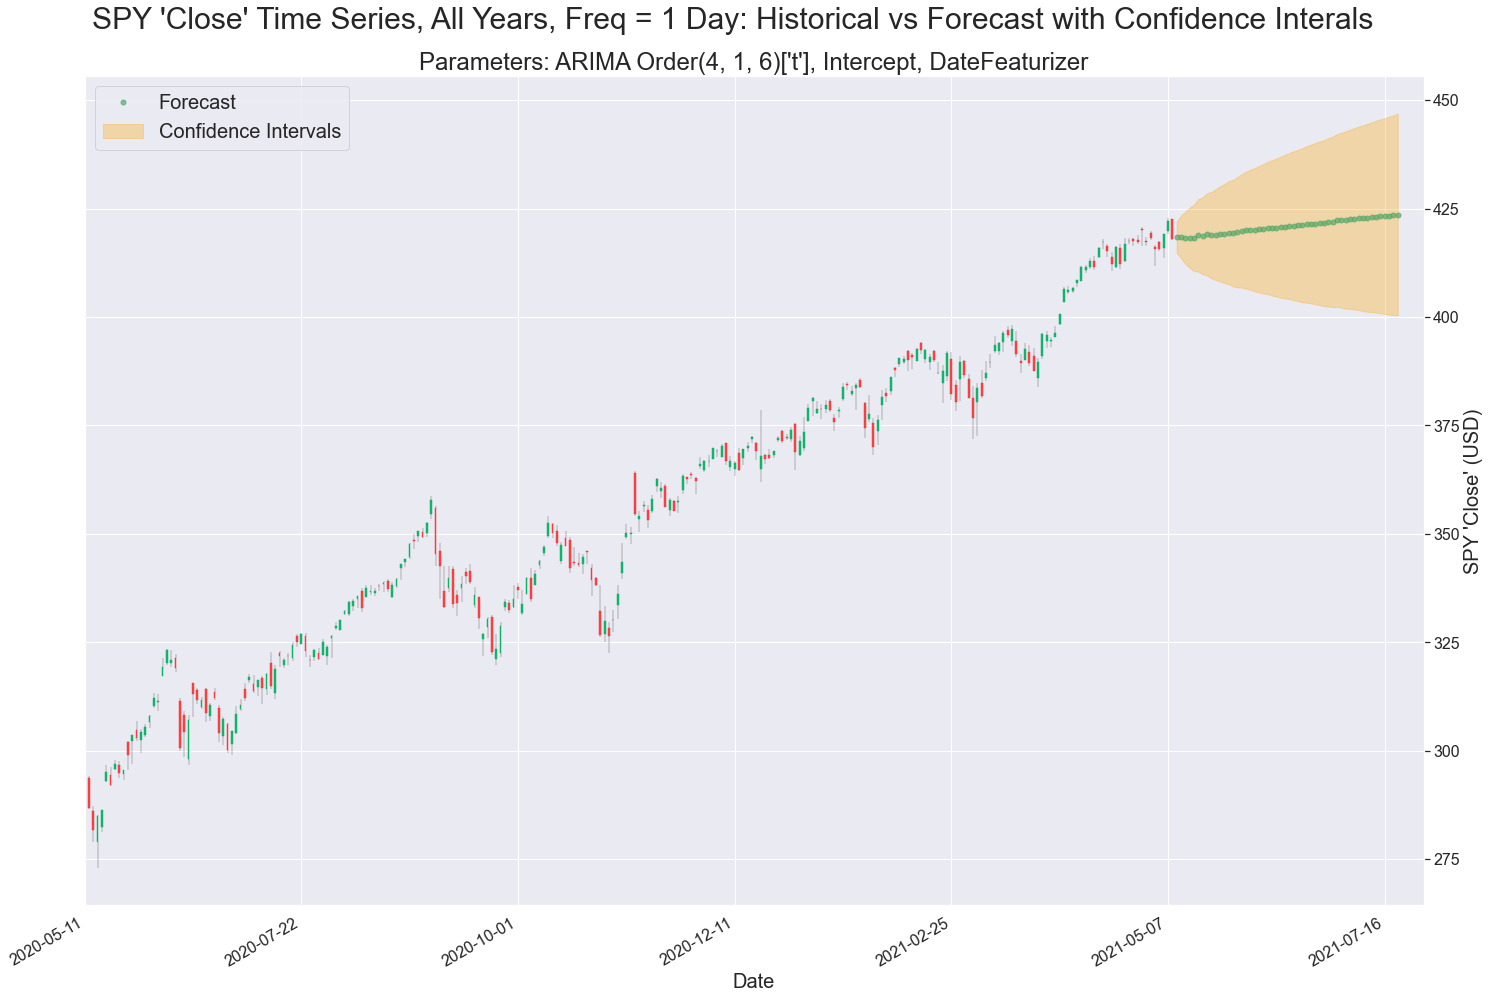

In [559]:
pam_all_close = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80, order=(4, 1, 6),
                               n='All', periods='years', freq='1 Day', seas=261, fit_seas=False,
                               with_intercept='True', trend='t',
                               estimate_diffs=True, impute=False, verbose=verbose,
                               date=True, fourier=False, box=False, log=False)
pam_all_model = pam_all_close.mod_pipe
# pam_all_close_auto = pam_all_close.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_all_close.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
close_all_hat_df, close_all_hat, new_dates_df, close_all_conf_ints = pam_all_close.run_prediction(pam_all_model, 52, fin=True,
                            exog_df=opt_exp_fc_df, en_ex='endo', ohlc_df=spy_df_all, func='adhoc', lookback=252, verbose=1, visualize=True)

In [561]:
close_all_conf_ints[-1]

array([400.37601555, 446.87964107])

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


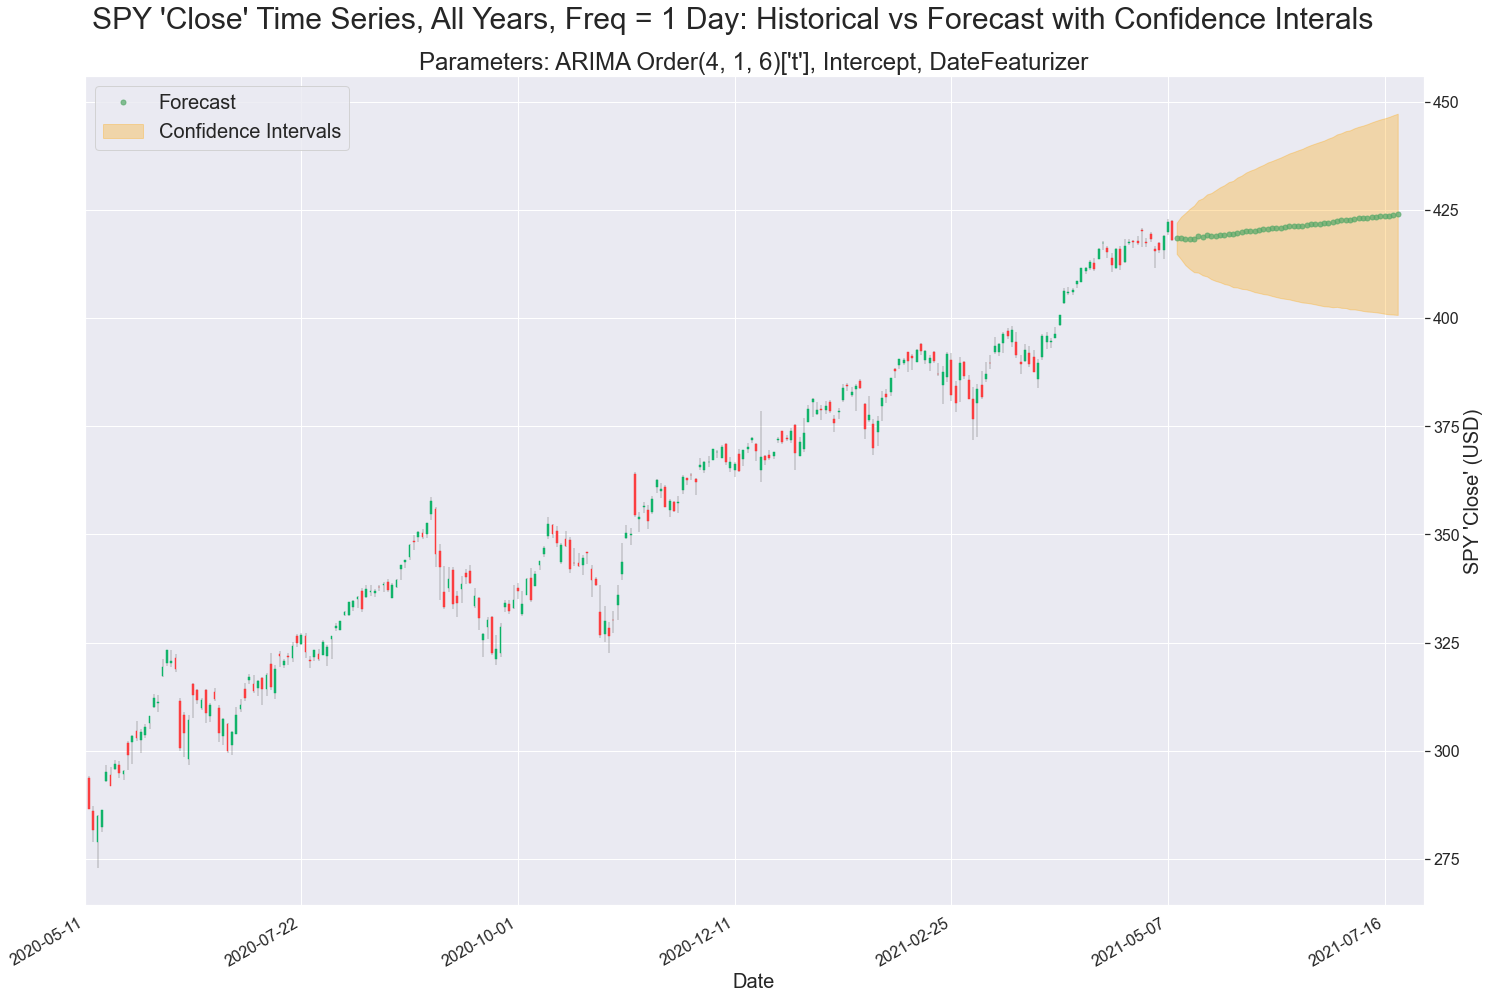

In [562]:
pam_all_close = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80, order=(4, 1, 6),
                               n='All', periods='years', freq='1 Day', seas=261, fit_seas=False,
                               with_intercept='True', trend='t',
                               estimate_diffs=True, impute=False, verbose=verbose,
                               date=True, fourier=False, box=False, log=False)
pam_all_model = pam_all_close.mod_pipe
close_all_hat_df, close_all_hat, new_dates_df, close_all_conf_ints = pam_all_close.run_prediction(pam_all_model, 52, fin=True, hist_df=hist_df,
                            exog_df=opt_exp_fc_df, en_ex='endo', ohlc_df=spy_df_all, func='adhoc', lookback=252, verbose=1, visualize=True)

In [563]:
close_all_conf_ints[-1]

array([400.73773798, 447.24352842])

In [550]:
hist_en_ex_df = pd.DataFrame(df_all_close).join(opt_exp_all_df)
hist_en_ex_df.reset_index(inplace=True)
hist_en_ex_df

,date,close,is_option_expiry
0,1993-01-29,43.937500,1
1,1993-02-01,44.250000,1
2,1993-02-02,44.343750,0
3,1993-02-03,44.812500,1
4,1993-02-04,45.000000,0
...,...,...,...
7116,2021-05-04,415.619995,0
7117,2021-05-05,415.750000,1
7118,2021-05-06,419.070007,0
7119,2021-05-07,422.119995,1


In [555]:
close_all_hat_df

,spy 'close'
date,
2021-05-11,418.110089
2021-05-12,418.229973
2021-05-13,418.316930
2021-05-14,418.354832
2021-05-17,418.434916
...,...
2021-07-15,423.455049
2021-07-16,423.493673
2021-07-19,423.574479


In [626]:
df_all_vol.mean()

84521873.77868277

In [641]:
df_all_vol

date
1993-01-29      1003200
1993-02-01       480500
1993-02-02       201300
1993-02-03       529400
1993-02-04       531500
                ...    
2021-05-04    101591200
2021-05-05     39960700
2021-05-06     74321400
2021-05-07     67680100
2021-05-10     74259578
Freq: C, Name: volume, Length: 7121, dtype: int64

### Using is_option_expiry and volume

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Exogenous variable SPY 'Volume'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


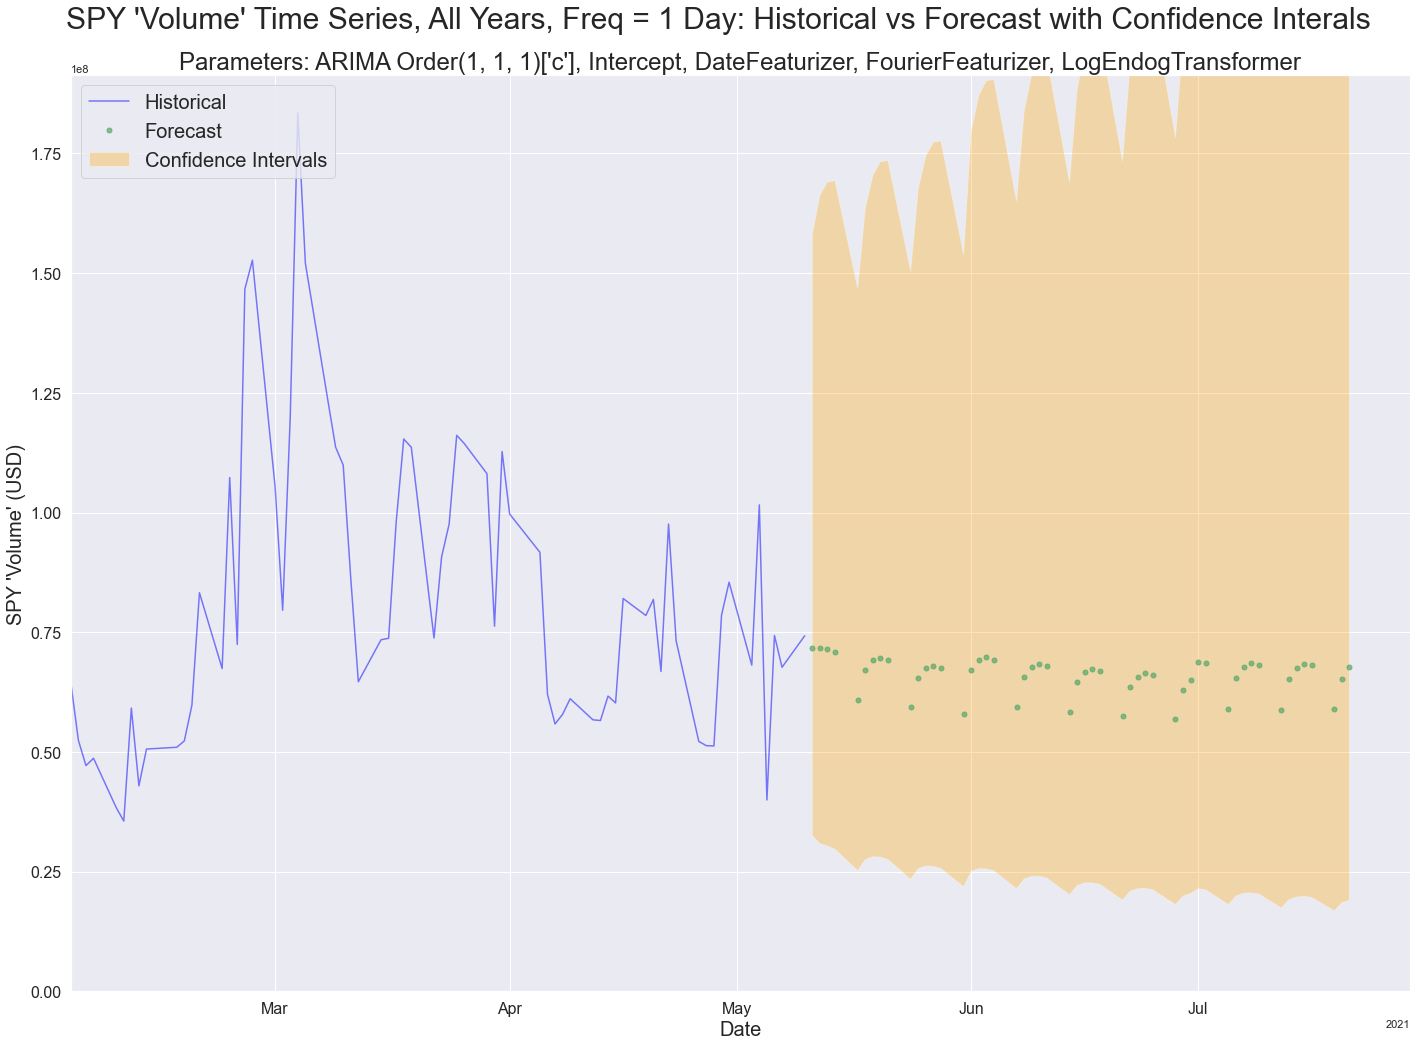

In [636]:
pam_all_vol = Pmdarima_Model(df_all_vol, 'SPY \'Volume\'', train_size=80, order=(1, 1, 1),
                               n='All', periods='years', freq='1 Day', seas=261, f_seas=252, k=2, fit_seas=False,
                               with_intercept='True', trend='c',
                               estimate_diffs=True, impute=False, verbose=verbose,
                               date=True, fourier=True, box=False, log=True)
# pam_all_close_auto = pam_all_close.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_all_close.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
vol_all_hat_df, vol_all_hat, new_dates_df, vol_all_conf_ints = pam_all_vol.run_prediction(pam_all_vol.mod_pipe, 52, fin=False,
                            en_ex='exog', func='adhoc', lookback=252, verbose=1, visualize=True)

In [658]:
new_dates_df

,date
7121,2021-05-11
7122,2021-05-12
7123,2021-05-13
7124,2021-05-14
7125,2021-05-17
...,...
7168,2021-07-15
7169,2021-07-16
7170,2021-07-19
7171,2021-07-20


In [659]:
vol_all_hat_df

,spy 'volume'
7121,7.167447e+07
7122,7.161890e+07
7123,7.158267e+07
7124,7.087480e+07
7125,6.080668e+07
...,...
7168,6.843055e+07
7169,6.822505e+07
7170,5.886877e+07
7171,6.531081e+07


In [661]:
opt_exp_fc_df_mod = opt_exp_fc_df

In [668]:
opt_exp_fc_df.index = new_dates_df.index

In [669]:
all_exog_df = Pmdarima_Model.join_exog_data(new_dates_df,
                                            opt_exp_fc_df,
                                            vol_all_hat_df)
all_exog_df.columns = ['date', 'is_option_expiry', 'volume']
all_exog_df

,date,is_option_expiry,volume
7121,2021-05-11,0,7.167447e+07
7122,2021-05-12,1,7.161890e+07
7123,2021-05-13,0,7.158267e+07
7124,2021-05-14,1,7.087480e+07
7125,2021-05-17,1,6.080668e+07
...,...,...,...
7168,2021-07-15,0,6.843055e+07
7169,2021-07-16,1,6.822505e+07
7170,2021-07-19,1,5.886877e+07
7171,2021-07-20,0,6.531081e+07


Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


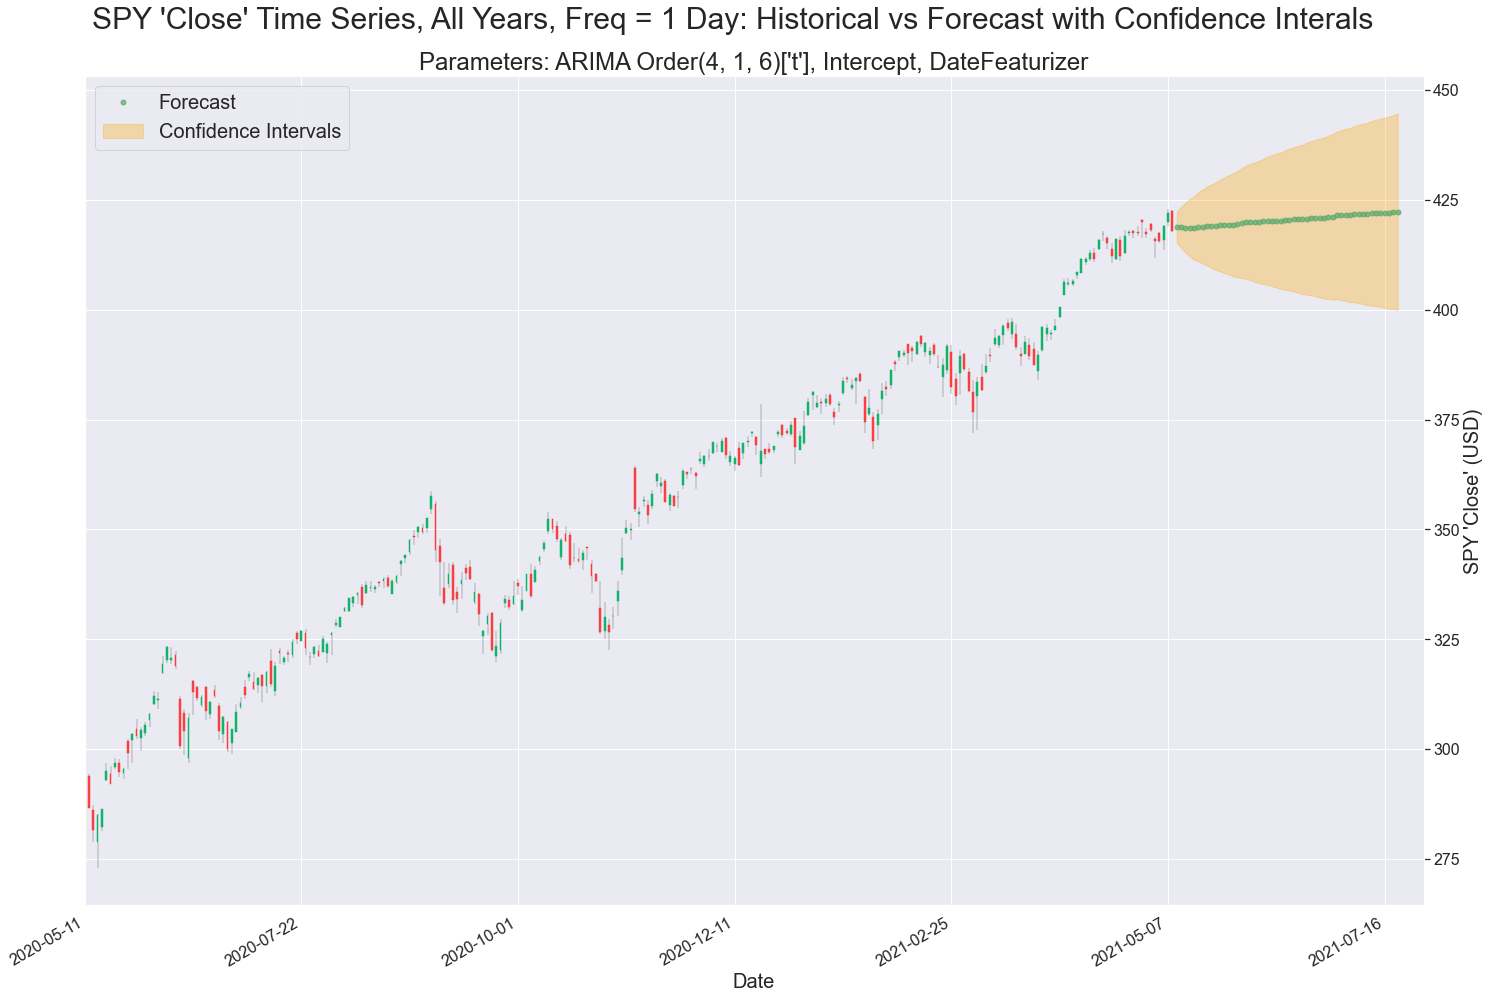

In [648]:
pam_all_close_v_x = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80, order=(4, 1, 6),
                               n='All', periods='years', freq='1 Day', seas=261, fit_seas=False,
                               with_intercept='True', trend='t',
                               estimate_diffs=True, impute=False, verbose=verbose,
                               date=True, fourier=False, box=False, log=False)
pam_all_model = pam_all_close.mod_pipe
close_all_hat_df, close_all_hat, new_dates_df, close_all_conf_ints = pam_all_close.run_prediction(pam_all_model, 52, fin=True, hist_df=hist_df,
                            exog_df=all_exog_df, en_ex='endo', ohlc_df=spy_df_all, func='adhoc', lookback=252, verbose=1, visualize=True)

In [649]:
close_all_conf_ints[-1]

array([400.01993652, 444.62648818])

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


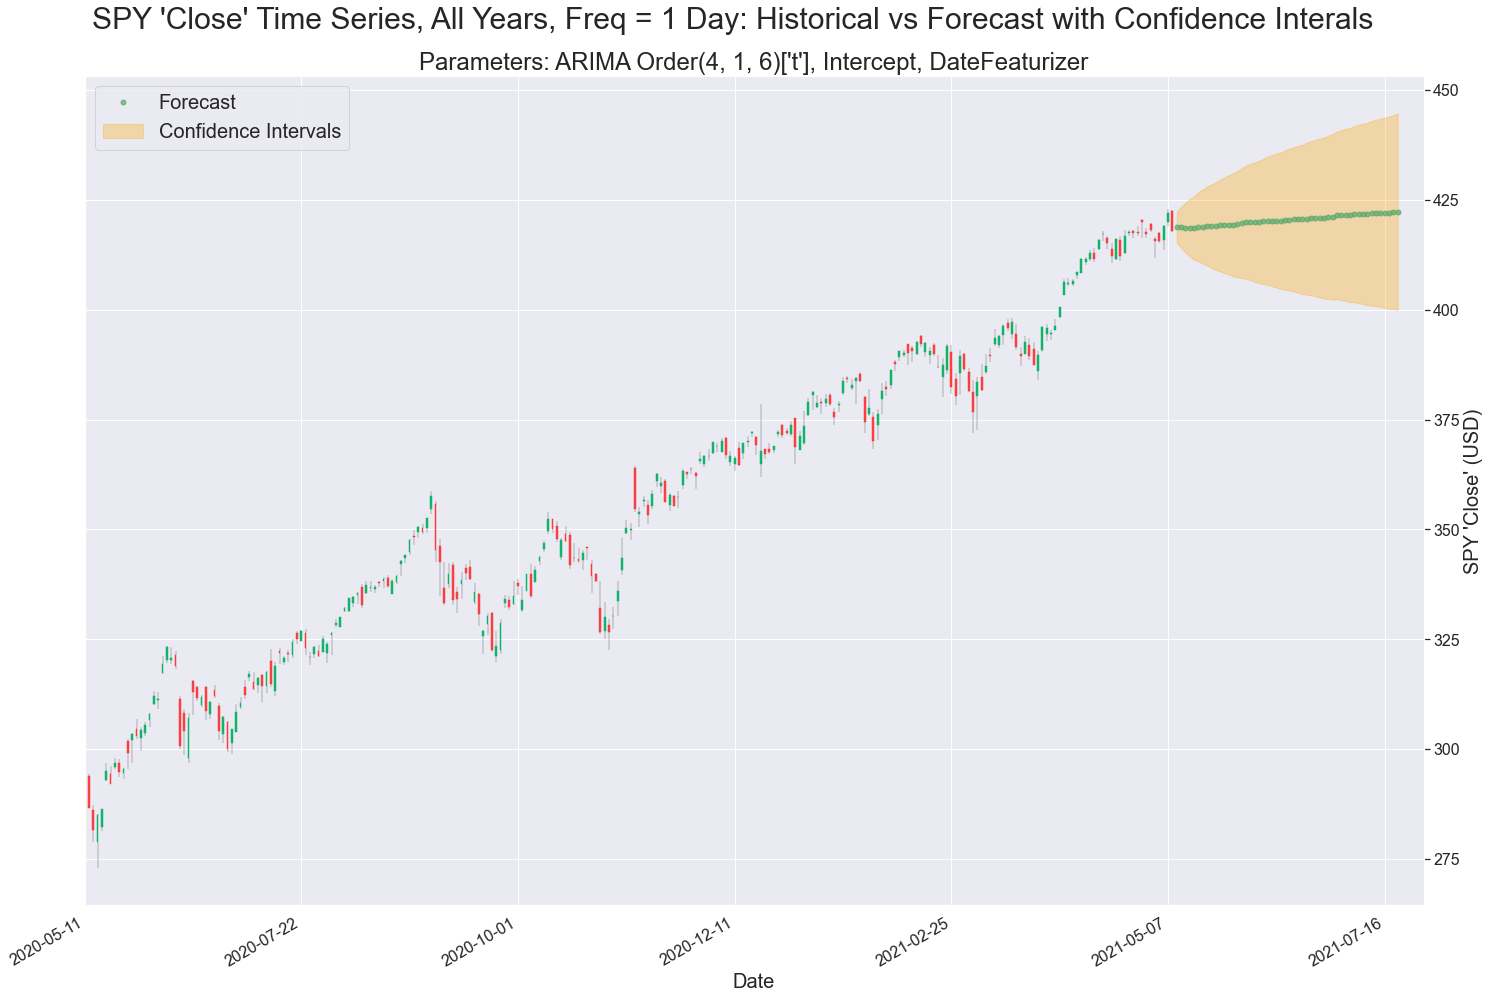

In [650]:
pam_all_close_v_x = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80, order=(0, 1, 0),
                               n='All', periods='years', freq='1 Day', seas=261, fit_seas=False,
                               with_intercept='True', trend='t',
                               estimate_diffs=True, impute=False, verbose=verbose,
                               date=True, fourier=False, box=False, log=False)
pam_all_model = pam_all_close.mod_pipe
close_all_hat_df, close_all_hat, new_dates_df, close_all_conf_ints = pam_all_close.run_prediction(pam_all_model, 52, fin=True, hist_df=hist_df,
                            exog_df=all_exog_df, en_ex='endo', ohlc_df=spy_df_all, func='adhoc', lookback=252, verbose=1, visualize=True)

## Last 5 Days, 1min

### Train-Test Split

In [ ]:
# round((80/100)*len(df))

In [41]:
# df_train, df_test = train_test_split_data(df, 80)
df_train_last_5d_1min, df_test_last_5d_1min = train_test_split_data(df_last_5d_1min_close, 80)
vol_train_last_5d_1min, vol_test_last_5d_1min = train_test_split_data(vol_last_5d_1min, 80)

#### No Seasonality

In [ ]:
# Train Set
pm.auto_arima(vol_train_last_5d_1min.dropna()).summary()

In [45]:
# Full Set
pm.auto_arima(vol_last_5d_1min.dropna()).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3927
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -52221.109
Date:                Thu, 29 Apr 2021   AIC                         104462.219
Time:                        17:04:07   BIC                         104524.972
Sample:                             0   HQIC                        104484.484
                               - 3927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3895      0.078     -5.005      0.000      -0.542      -0.237
ar.L2         -0.0796      0.041     -1.920      0.055      -0.161       0.002
ar.L3          0.4202      0.062      6.764      0.000       0.298       0.542
ar.L4          0.5403      0.063      8.637      0.000       0.418       0.663
ma.L1         -0.2453      0.077     -3.172      0.002      -0.397      -0.094
ma.L2         -0.2847      0.071     -4.009      0.000      -0.424      -0.146
ma.L3         -0.5526      0.067     -8.193      0.000      -0.685      -0.420
ma.L4         -0.3067      0.095     -3.213      0.001      -0.494      -0.120
ma.L5          0.4222      0.035     11.942      0.000       0.353       0.492
sigma2      2.146e+10   3.57e-11   6.01e+20      0.000    2.15e+10    2.15e+10
===================================================================================
Ljung-Box (Q):                       67.42   Jarque-Bera (JB):           3955420.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             8.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       157.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+35. Standard errors may be unstable.
"""

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(vol_train_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(vol_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

In [ ]:
# param_list = []
# param_seasonal_list = []
# aic_list = []

In [ ]:
# param = (2,1,0)
# param_seasonal = (2,1,0,2190)

In [ ]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [ ]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

## Auto ARIMA

In [ ]:
# pm.auto_arima(df.dropna(), seasonal=True, m=2190).summary()
# pm.auto_arima(df.dropna(), seasonal=True, m=round(365/4)).summary()

### Last 5 Days, 1min - `Close`

In [ ]:
# Train Set
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min).summary()

In [46]:
# Full Set
pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3927
Model:               SARIMAX(1, 1, 3)   Log Likelihood                3921.866
Date:                Thu, 29 Apr 2021   AIC                          -7833.733
Time:                        17:05:14   BIC                          -7802.356
Sample:                             0   HQIC                         -7822.600
                               - 3927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8036      0.061    -13.280      0.000      -0.922      -0.685
ma.L1          0.8304      0.062     13.422      0.000       0.709       0.952
ma.L2         -0.0064      0.010     -0.628      0.530      -0.026       0.014
ma.L3         -0.0552      0.008     -7.132      0.000      -0.070      -0.040
sigma2         0.0079   5.38e-05    147.619      0.000       0.008       0.008
===================================================================================
Ljung-Box (Q):                       72.61   Jarque-Bera (JB):             87775.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min, seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(df_last_5d_1min.dropna(), exog=vol_last_5d_1min, seasonal=True, m=24*60).summary()

In [ ]:
# pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min, exog=vol_train, seasonal=True, m=16*5).summary()

## SARIMAX Fitting

In [ ]:
df_test_last_5d_1min

In [ ]:
df_train_last_5d_1min.isna().index

In [ ]:
df_test_last_5d_1min

### Last 5 Days, Freq = Minute

#### No Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
# sari_mod_volume.summary()
# failed to converge

In [40]:
sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
sari_mod_volume.summary()

NameError: name 'vol_train_last_5d_1min' is not defined

In [ ]:
sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,3), exog=vol_train_last_5d_1min.dropna()).fit()
sari_mod_close.summary()

#### 1 Day Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(1,1,0),seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_volume.summary()

In [ ]:
# sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,0), exog=vol_train_last_5d_1min.dropna(), seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_close.summary()

In [ ]:
df_test_last_5d_1min.index[0]

## Simple Test vs Predict

### Last 5 Days, 1min - `Volume`

#### No Seasonality

In [ ]:
v_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
v_hat_test_last_5d_1min = sari_mod_close.predict(start=vol_test_last_5d_1min.index[0], end=vol_test_last_5d_1min.index[-1], typ='levels')

### Last 5 Days, 1min - `Close`

In [ ]:
y_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
y_hat_test_last_5d_1min = sari_mod_close.predict(start=df_test_last_5d_1min.index[0], end=df_test_last_5d_1min.index[-1], typ='levels')

#### 1 Day Seasonality

### Visualization

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train_last_5d_1min, label='Train')
ax.plot(df_test_last_5d_1min, label='Test')
ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

In [ ]:
# fig, ax = plt.subplots(figsize = (10,8))
# ax.plot(df_train_last_5d_1min, label='Train')
# ax.plot(df_test_last_5d_1min, label='Test')
# ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
# ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
# ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
# plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# plt.legend()

In [ ]:
y_hat_train.idxmax()

In [ ]:
y_hat_train.max()

In [ ]:
y_hat_train.drop(y_hat_train.idxmax(), inplace=True)

In [ ]:
y_hat_test

## SARIMAX Forecasting

### Volume

In [118]:
sari_mod_vol_fc = SARIMAX(vol_last_5d_1min,order=(4,1,5)).fit()
sari_mod_vol_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 volume   No. Observations:                 9600
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -54227.908
Date:                Fri, 30 Apr 2021   AIC                         108457.817
Time:                        11:06:48   BIC                         108464.986
Sample:                    04-22-2021   HQIC                        108460.248
                         - 04-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.224e+10   1.43e+07    857.658      0.000    1.22e+10    1.23e+10
===================================================================================
Ljung-Box (Q):                     1865.38   Jarque-Bera (JB):          37156945.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       307.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

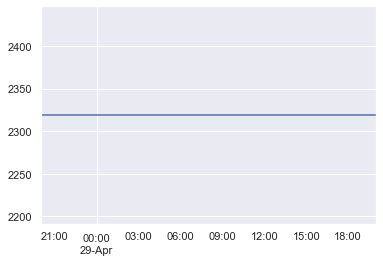

In [119]:
vol_fc = sari_mod_vol_fc.forecast(steps=24*60)
vol_fc
vol_fc.plot()

In [49]:
vol_last_5d_1min

time
2021-04-22 04:01:00    9244.0
2021-04-22 04:02:00    2860.0
2021-04-22 04:03:00    2990.0
2021-04-22 04:04:00     510.0
2021-04-22 04:05:00    1011.0
                        ...  
2021-04-28 19:56:00    6269.0
2021-04-28 19:57:00    1574.0
2021-04-28 19:58:00    2127.0
2021-04-28 19:59:00    4522.0
2021-04-28 20:00:00    2319.0
Freq: T, Name: volume, Length: 9600, dtype: float64

2021-04-28 20:01:00    2630.872724
2021-04-28 20:02:00    2582.473395
2021-04-28 20:03:00    2549.816560
2021-04-28 20:04:00    2472.193725
2021-04-28 20:05:00    2487.613057
                          ...     
2021-04-29 19:56:00    2332.136072
2021-04-29 19:57:00    2332.136072
2021-04-29 19:58:00    2332.136072
2021-04-29 19:59:00    2332.136072
2021-04-29 20:00:00    2332.136072
Freq: T, Length: 1440, dtype: float64

In [51]:
vol_cat = vol_last_5d_1min.append(vol_fc)
vol_cat

2021-04-22 04:01:00    9244.00000
2021-04-22 04:02:00    2860.00000
2021-04-22 04:03:00    2990.00000
2021-04-22 04:04:00     510.00000
2021-04-22 04:05:00    1011.00000
                          ...    
2021-04-29 19:56:00    8115.18893
2021-04-29 19:57:00    8115.18893
2021-04-29 19:58:00    8115.18893
2021-04-29 19:59:00    8115.18893
2021-04-29 20:00:00    8115.18893
Freq: T, Length: 11040, dtype: float64

In [63]:
df_last_5d_1min_close[df_last_5d_1min_close.isna()].index.size

5673

In [58]:
vol_cat[vol_cat.isna()].index.size

5673

In [69]:
df_int = df_last_5d_1min_close.interpolate()
df_int

In [78]:
vol_int = vol_last_5d_1min.interpolate()
vol_int

### Close

In [106]:
# exog cannot have NaN
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min, order=(1,1,3)).fit()

sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min.interpolate(), order=(0,0,0)).fit()
sari_mod_close_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 9600
Model:                        SARIMAX   Log Likelihood              -43193.578
Date:                Fri, 30 Apr 2021   AIC                          86391.156
Time:                        11:00:40   BIC                          86405.495
Sample:                    04-22-2021   HQIC                         86396.020
                         - 04-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume         0.0008      0.037      0.023      0.982      -0.071       0.073
sigma2      5.694e+08   2.24e-14   2.54e+22      0.000    5.69e+08    5.69e+08
===================================================================================
Ljung-Box (Q):                   133799.92   Jarque-Bera (JB):             29523.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+40. Standard errors may be unstable.
"""

In [101]:
sari_mod_close_fc = SARIMAX(df_int, exog=vol_int, order=(1,1,3)).fit()
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_int, order=(1,1,3)).fit()

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
# sari_mod_last = SARIMAX(df_last, order=(1,1,0), seasonal_order=(1,1,0,16)).fit()
# sari_mod_last = SARIMAX(df_last.dropna(), order=(1,1,0), seasonal_order=(1,1,0,16), exog=vol_last.dropna()).fit()
sari_mod_close_fc.summary()

In [107]:
close_fc = sari_mod_close_fc.forecast(steps=24*60, exog = vol_fc)

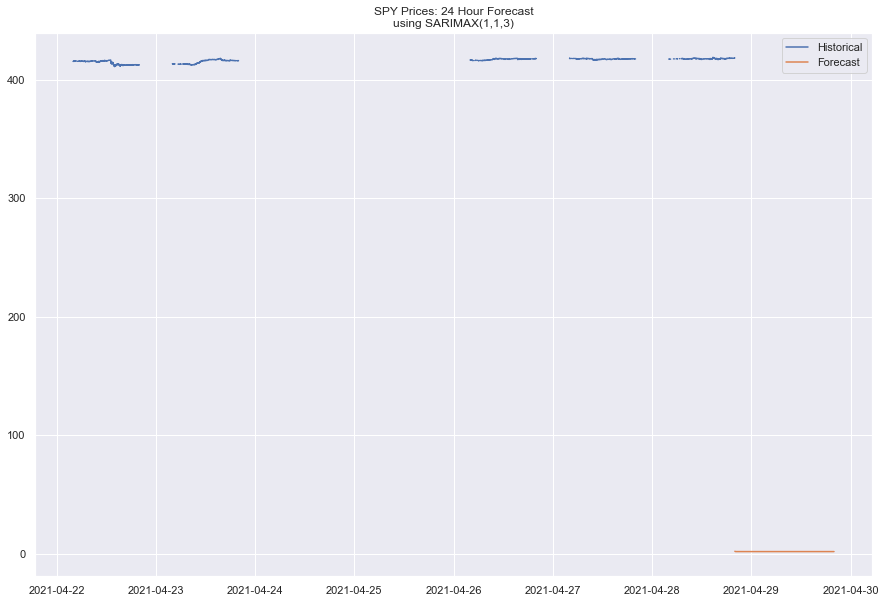

In [108]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_last_5d_1min_close, label='Historical')
ax.plot(close_fc, label='Forecast')
ax.set_title('SPY Prices: 24 Hour Forecast\nusing SARIMAX(1,1,3)')
plt.legend()

## Facebook Prophet

In [ ]:
df_pro = pd.DataFrame(df.reset_index())
df_pro.columns = ['ds','y']

In [ ]:
df_pro

In [ ]:
promod = prophet.Prophet()
promod.fit(df_pro)

In [ ]:
future = promod.make_future_dataframe(periods=16, freq=cbh)
future.tail(32)

In [ ]:
forecast = promod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
df_pro[-16:]

In [ ]:
forecast[-32:]

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
promod.plot(forecast, ax=ax);
# start = pd.to_datetime('2021-04-23')
# end = pd.to_datetime('2021-04-26')
# ax.set_xlim(start,end)

In [ ]:
forecast.yhat.plot()

In [ ]:
fig2 = promod.plot_components(forecast)


# Calculating Profit

## Calculation Profit using Buy & Hold Strategy

In [29]:
bh_profit, bh_profit_pc, bh_profit_df = calc_buy_hold_profit(spy_df_3Y, shares=100, freq=CBD)

Final portfolio value is $41,421.00.
Total profit is $14,923.00, which is a 56.32% profit.


In [260]:
bh_profit_df

,market_value,eod_profit,eod_profit_pc
date,,,
2018-05-01,5.299600e+06,0.000000e+00,0.000000
2018-05-02,5.264000e+06,-3.559998e+04,-0.671748
2018-05-03,5.252400e+06,-4.720032e+04,-0.890639
2018-05-04,5.320400e+06,2.079956e+04,0.392474
2018-05-07,5.338400e+06,3.880005e+04,0.732132
...,...,...,...
2021-05-05,8.315000e+06,3.015400e+06,56.898627
2021-05-06,8.381400e+06,3.081800e+06,58.151555
2021-05-07,8.442400e+06,3.142800e+06,59.302580


In [281]:
2-stats.norm.cdf(1)*2

0.31731050786291415

## Calculating Profit using Model Outputs

### 3Y

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
min_p 5
Building list of models to test.
ARIMA Order(5, 1, 5)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(6, 1, 4)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already presen

________________________________________________________________________

Running step-wise cross-validation on model 1 of 4... 
ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(5, 1, 6), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4223.757 | RMSE: 3.501 | RMSE%=1.196% | SMAPE 0.736%
Successfully completed step-wise CV on model.
Model[ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4223.757 | RMSE=3.501 | RMSE_pc=1.196% | SMAPE=0.736%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=3.501
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_3Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_3Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 942.
Adding scores to model, updating line 942.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 4... 
ARIMA Order(5, 1, 7)['t

> 

Done.
AIC: 4221.788 | RMSE: 3.646 | RMSE%=1.246% | SMAPE 0.780%
Successfully completed step-wise CV on model.
Model[ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer]: AIC=4221.788 | RMSE=3.646 | RMSE_pc=1.246% | SMAPE=0.780%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 943.
Adding scores to model, updating line 943.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 4... 
ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(6, 1, 5), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4223.280 | RMSE: 3.519 | RMSE%=1.202% | SMAPE 0.739%
Successfully completed step-wise CV on model.
Model[ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4223.280 | RMSE=3.519 | RMSE_pc=1.202% | SMAPE=0.739%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 944.
Adding scores to model, updating line 944.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 4... 
ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(6, 1, 6), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4222.863 | RMSE: 3.505 | RMSE%=1.198% | SMAPE 0.742%
Successfully completed step-wise CV on model.
Model[ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4222.863 | RMSE=3.505 | RMSE_pc=1.198% | SMAPE=0.742%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 945.
Adding scores to model, updating line 945.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(5, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4223.757 | RMSE=3.501 | RMSE%=1.196% | SMAPE=0.736%
Model[ARIMA Order(6, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4222.863 | RMSE=3.505 | RMSE%=1.198% | SMAPE=0.742%
Model[ARIMA Order(6, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4223.280 | RMSE=3.519 | RMSE%=1.202% | SMAPE=0.739%
Model[ARIMA Order(5, 1, 7)['t'], Intercept, DateFeaturizer]: AIC=4221.788 | RMSE=3.646 | RMSE%=1.246% | SMAPE=0.780%


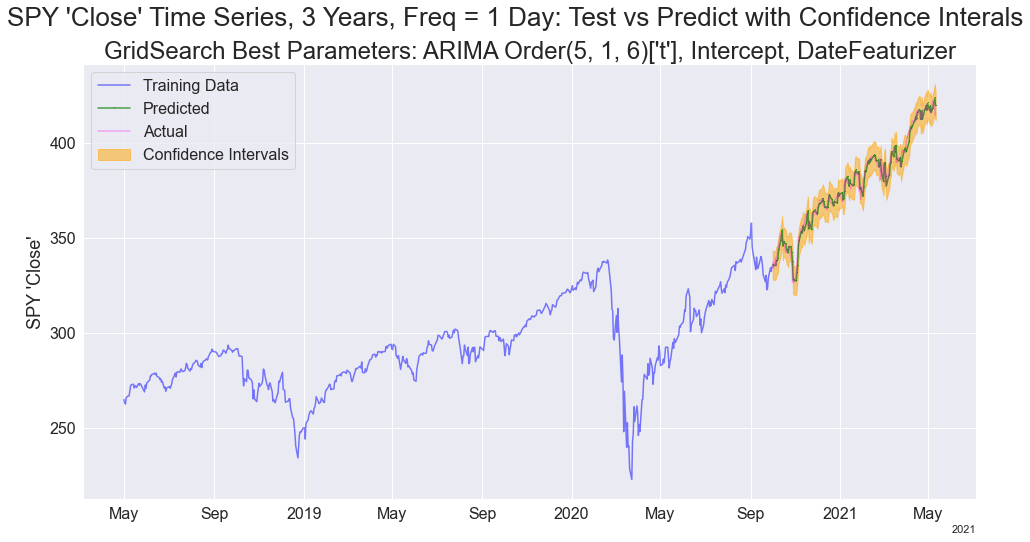

In [55]:
pam_3Y_close = Pmdarima_Model(df_3Y_close, 'SPY \'Close\'', n=3, periods='years', freq='1 Day', train_size=80,
                        order=(0,1,0), f_seas=252, fit_seas=False, #with_intercept=False, trend='t',
                        estimate_diffs=True, impute=False, verbose=1, k=4,
                        date=True, fourier=False, box=False, log=False)
pam_3Y_best, scores = pam_3Y_close.run_gridsearch_CV(min_order=10, max_order=12, min_d=1, max_d=1, min_p=5, max_p=6, min_q=4, max_q=10,
                                    with_intercept=True, f_m=252, k=2, t_list=['t'],
                                    fourier=False, box=False, log=False, max_models=0, debug=True, verbose=1, parallel=False)

In [23]:
pam_3Y_close = Pmdarima_Model(df_3Y_close, 'SPY \'Close\'', n=3, periods='years', freq='1 Day', train_size=80,
                        order=(0,1,1), fit_seas=False, with_intercept=True, trend='t',
                        estimate_diffs=True, impute=False, verbose=1, #f_seas=252, k=4,
                        date=True, fourier=False, box=False, log=False)
# CV_scores = pam_3Y_close.run_stepwise_CV(func='adhoc', dynamic=False, verbose=1, visualize=True)

Successfully created instance of Class Pmdarima_Model.


In [24]:
pam_3Y_best = pam_3Y_close.mod_pipe

In [30]:
y_hat, conf_ints = pam_3Y_best.predict_in_sample(X=exog_hist_3Y_df, return_conf_int=True)

In [19]:
# unpickle model
mod_dat = unpickle_data("../models/SPY_'Close'_3Y_1D_GS_best_model.pkl")
best_mod = mod_dat[1]
best_mod

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 2, 2), suppress_warnings=True,
                       trend='c'))])

In [25]:
# historical exog variables
exog_hist_3Y_df = opt_exp_3Y_df.join(df_3Y_vol)
exog_hist_3Y_df.reset_index(inplace=True)
exog_hist_3Y_df

,date,is_option_expiry,volume
0,2018-05-01,0,74203400
1,2018-05-02,1,86368900
2,2018-05-03,0,136311500
3,2018-05-04,1,91222100
4,2018-05-07,1,55304900
...,...,...,...
758,2021-05-05,1,39960700
759,2021-05-06,0,74321400
760,2021-05-07,1,67680100
761,2021-05-10,1,81689700


In [729]:
spy_df_10Y

,open,high,low,close,adj_close,volume
date,,,,,,
2011-05-02,137.070007,137.179993,135.949997,136.220001,111.753159,126278700
2011-05-03,135.960007,136.190002,135.039993,135.729996,111.351181,138375000
2011-05-04,135.669998,135.729996,134.229996,134.830002,110.612801,182678500
2011-05-05,134.080002,134.949997,133.020004,133.610001,109.611984,226900000
2011-05-06,134.940002,135.630005,133.679993,134.199997,110.096001,222787200
...,...,...,...,...,...,...
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700
2021-05-06,415.829987,419.209991,413.679993,419.070007,419.070007,74321400
2021-05-07,419.890015,422.820007,419.160004,422.119995,422.119995,67680100


In [728]:
exog_10Y_hist_df

,date,is_option_expiry,volume
0,2011-05-02,1,126278700
1,2011-05-03,0,138375000
2,2011-05-04,1,182678500
3,2011-05-05,0,226900000
4,2011-05-06,1,222787200
...,...,...,...
2519,2021-05-05,1,39960700
2520,2021-05-06,0,74321400
2521,2021-05-07,1,67680100
2522,2021-05-10,1,81689700


In [ ]:
GS_3Y_mod_profit = Gridsearch_Calc_Profit('SPY 3Y', pam_3Y_best, spy_df_3Y, exog_hist_3Y_df, steps=40, z_min=0.5, z_max=2.5,
                                             lim_min=-1.5, lim_max=2.5, shares=100, verbose=1)
GS_3Y_mod_profit_df = GS_3Y_mod_profit.main()

Gridsearch_Calc_Profit.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


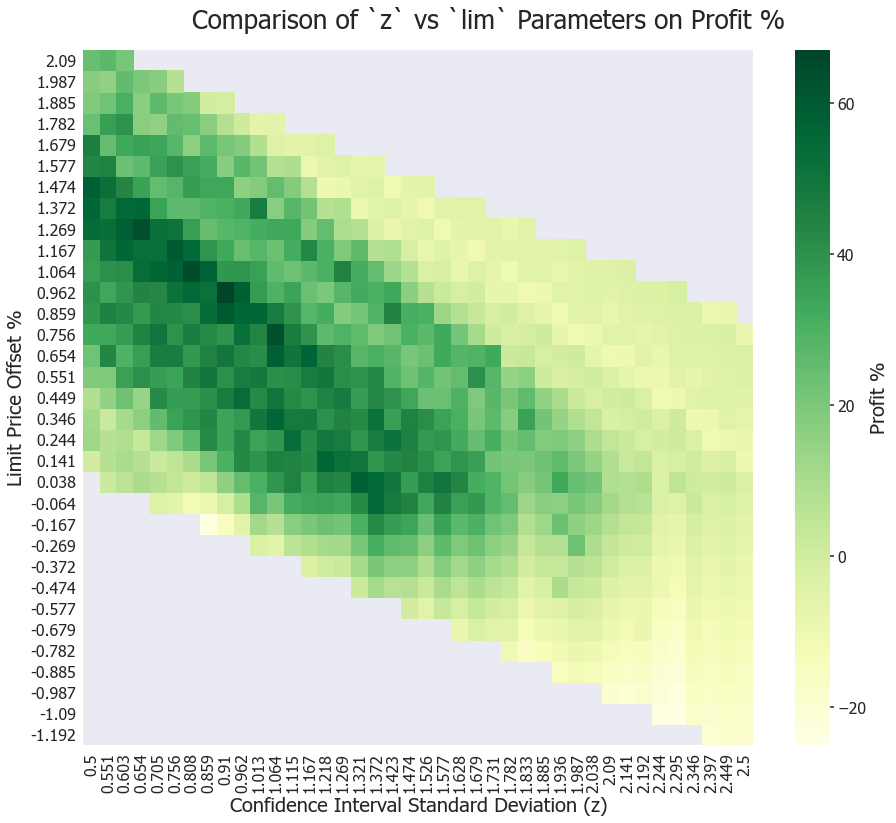

In [678]:
GS_3Y_mod_profit.plot_profit_heatmap()

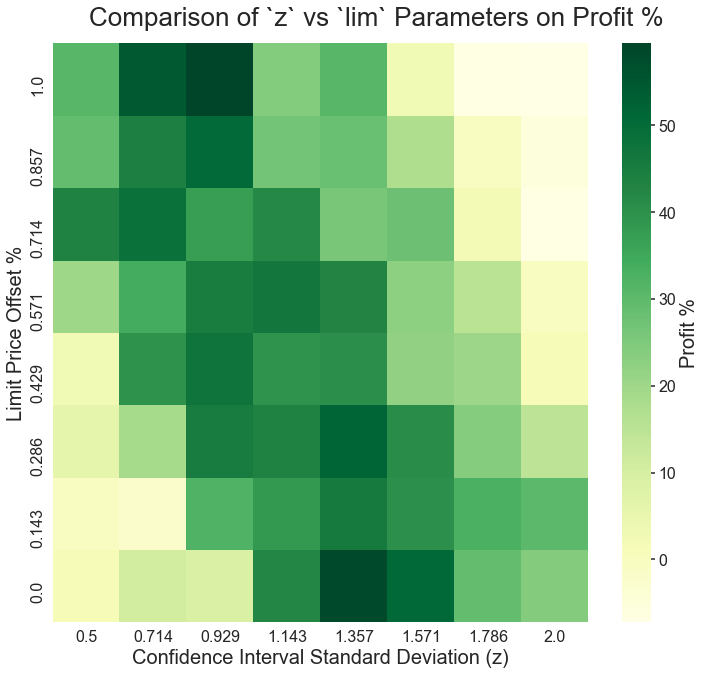

In [633]:
GS_3Y_mod_profit.plot_profit_heatmap()

In [687]:
z_min=0.5
z_max=2.5
lim_min=-1.5
lim_max=2.5
steps=40
z_list = np.linspace(z_min, z_max, steps)
lim_list = np.linspace(lim_min, lim_max, steps)

In [688]:
z_list, lim_list

(array([0.5  , 0.551, 0.603, 0.654, 0.705, 0.756, 0.808, 0.859, 0.91 ,
        0.962, 1.013, 1.064, 1.115, 1.167, 1.218, 1.269, 1.321, 1.372,
        1.423, 1.474, 1.526, 1.577, 1.628, 1.679, 1.731, 1.782, 1.833,
        1.885, 1.936, 1.987, 2.038, 2.09 , 2.141, 2.192, 2.244, 2.295,
        2.346, 2.397, 2.449, 2.5  ]),
 array([-1.5  , -1.397, -1.295, -1.192, -1.09 , -0.987, -0.885, -0.782,
        -0.679, -0.577, -0.474, -0.372, -0.269, -0.167, -0.064,  0.038,
         0.141,  0.244,  0.346,  0.449,  0.551,  0.654,  0.756,  0.859,
         0.962,  1.064,  1.167,  1.269,  1.372,  1.474,  1.577,  1.679,
         1.782,  1.885,  1.987,  2.09 ,  2.192,  2.295,  2.397,  2.5  ]))

In [ ]:
new_df = pd.DataFrame(np.zeros((8,8)), index=lim_list, columns=z_list)
for n_z, z in enumerate(z_list):
    for n_lim, lim in enumerate(lim_list):
        new_df.iloc[n_lim, n_z] = 1
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(new_df, ax=ax, cbar_kws={"label": "Profit %"}, cmap="YlGn")
ax.invert_yaxis()
ax.set_xlabel('Confidence Interval Standard Deviation (z)', size=20)
ax.set_ylabel('Limit Price Offset %', size=20)
# ax.set_yticklabels(np.linspace(lim_min, lim_max, steps).round(3)[::-1], va="center")
ax.tick_params(axis='x', **tick_params)
ax.tick_params(axis='y', **tick_params)

In [595]:
GS_3Y_mod_profit_pivot

z,0.500,0.714,0.929,1.143,1.357,1.571,1.786,2.000
Limit_Offset_pc,,,,,,,,
0.000,1.412058,10.626280,9.358462,42.311297,58.410133,50.703254,29.074533,24.118152
0.143,-0.045250,-2.138219,32.252126,38.339703,45.747995,40.374824,32.882588,30.470132
0.286,5.868288,18.674028,45.324372,43.609324,51.772077,41.169195,23.973592,14.883698
0.429,2.728807,39.943961,47.634828,39.641046,40.606656,21.987446,20.138516,1.560305
0.571,19.928239,34.174515,44.872603,46.599968,43.064520,22.729988,15.310862,-0.114914
0.714,43.465979,48.355115,37.298161,41.836152,26.064066,27.716860,2.563816,-6.851238
0.857,29.189129,44.325471,50.381248,26.827489,28.340427,17.305904,0.048153,-5.230042
1.000,30.985662,54.608122,59.503777,24.408822,30.927651,2.722983,-6.808818,-7.253118


In [613]:
GS_3Y_mod_profit_pivot.index

Float64Index([0.0, 0.143, 0.286, 0.429, 0.571, 0.714, 0.857, 1.0], dtype='float64', name='Limit_Offset_pc')

In [690]:
mod_sim_3Y = Model_Historical_Simuluation(pam_3Y_best, spy_df_3Y, exog_hist_3Y_df, shares=100, z=0.962,
                                          limit_offset_pc=0.962, start_date=None, verbose=0)
y_hat, conf_ints, mod_profit, mod_profit_pc, mod_profit_df = mod_sim_3Y.main()

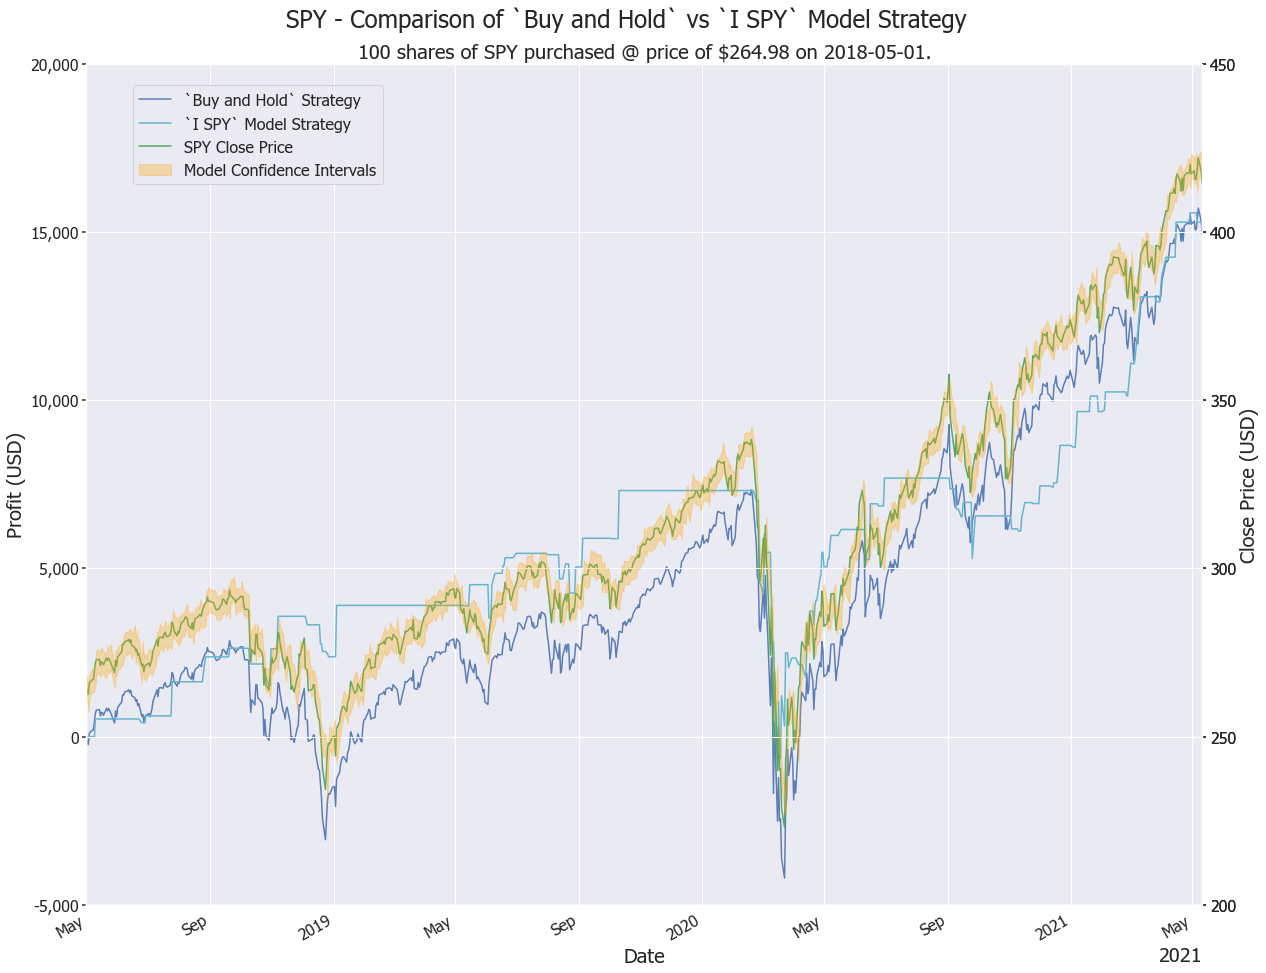

In [691]:
plot_profits(100, bh_profit_df, mod_profit_df, df_3Y_close, conf_ints)

### 10Y

In [758]:
mod_sim_10Y = Model_Historical_Simuluation(pam_10Y_best, spy_df_10Y, exog_10Y_hist_df, shares=100, z=0.962,
                                          limit_offset_pc=0.962, verbose=1)
y_hat, conf_ints, mod_profit, mod_profit_pc, mod_profit_df = mod_sim_10Y.main()

Running `I SPY` model historical simulation...



>_
Total profit is $7,639.34, which is a 56.08% profit.


In [766]:
bh_profit, bh_profit_pc, bh_profit_df = calc_buy_hold_profit(spy_df_10Y, shares=100)

Starting portfolio value was $13,622.00.
Final portfolio value is $41,421.00.
Total profit is $27,799.00, which is a 204.07% profit.


ValueError: operands could not be broadcast together with shapes (2524,) (763,) 

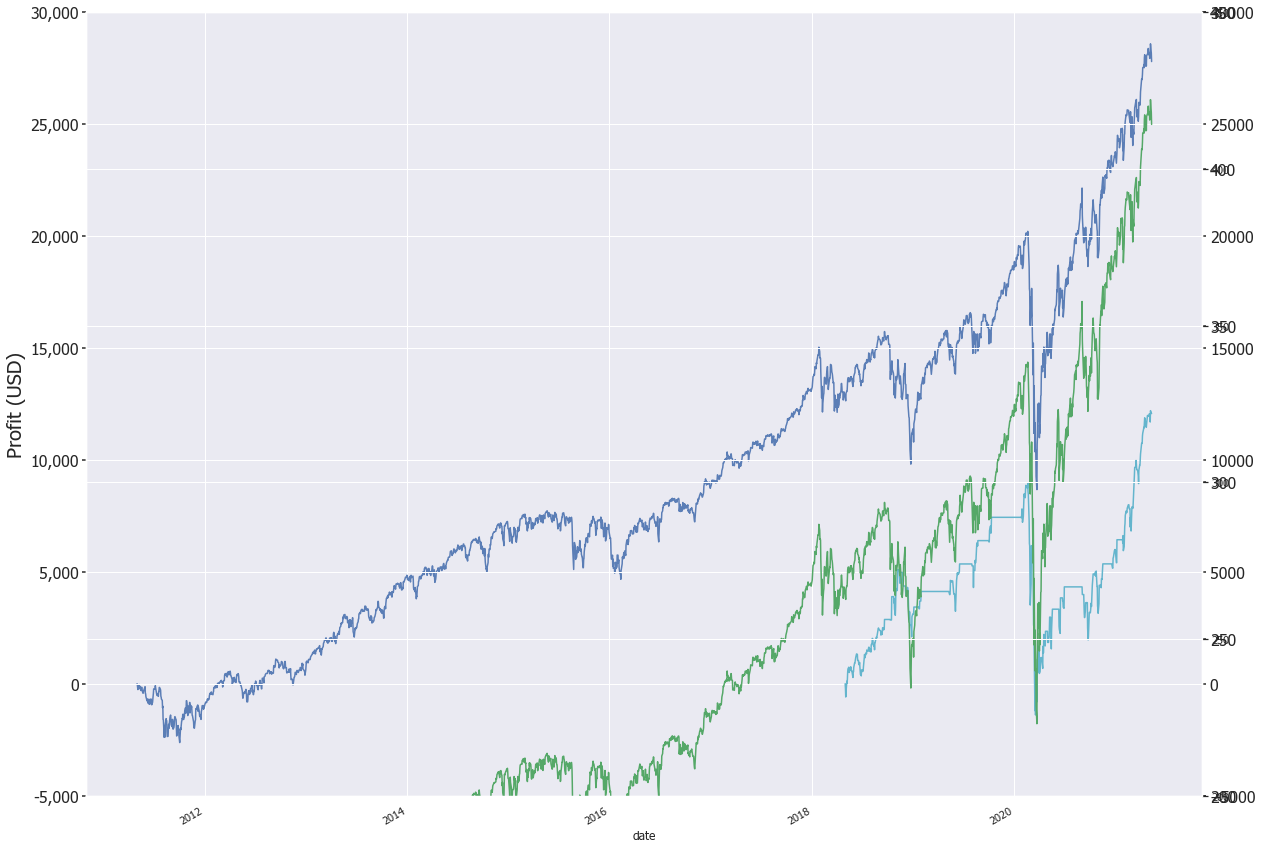

In [765]:
plot_profits(100, bh_profit_df, mod_profit_df, df_10Y_close, conf_ints)

In [734]:
pam_10Y_best = pm.pipeline.Pipeline(steps=[('fourier3', pm.preprocessing.FourierFeaturizer(k=2, m=1008)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])

In [737]:
exog_10Y_hist_df = opt_exp_10Y_df.join(df_10Y_vol)

In [738]:
GS_10Y_mod_profit = Gridsearch_Calc_Profit('SPY 10Y', pam_10Y_best, spy_df_10Y, exog_10Y_hist_df, steps=10, z_min=0.5, z_max=1,
                                             lim_min=0, lim_max=1, shares=100, verbose=1)

In [739]:
GS_10Y_mod_profit.main()

Running GridSearchCV on SPY 10Y model trading strategy...
Running 100 simulations using `z` in (0.5, 1) and `lim` in (0, 1).


Parameter standard deviations (z) = 0.5, Limit price offset percent = 0.111
Running `I SPY` model historical simulation...



ValueError: Length mismatch: Expected axis has 2524 elements, new values have 2 elements

In [ ]:
mod_profit_df.eod_profit_pc.max()abs(410.2432382 - 420.32567098)/df_10Y_close[-1]

In [770]:
(close_conf_ints[0][1] - close_conf_ints[0][0])/df_10Y_close[-1]

NameError: name 'close_conf_ints' is not defined

#### Single runs

In [768]:
new_mod = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=2, m=252)),
                ('fourier2', pm.preprocessing.FourierFeaturizer(k=2, m=252*4)),
                ('fourier3', pm.preprocessing.FourierFeaturizer(k=2, m=252/4)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])

In [769]:
mod_sim_3Y = Model_Historical_Simuluation(new_mod, spy_df_3Y, exog_hist_3Y_df, shares=100, z=0.02,
                                          limit_offset_pc=1.75, start_date=None, verbose=0)
y_hat, conf_ints, mod_profit, mod_profit_pc, mod_profit_df = mod_sim_3Y.main()